## Environment preparation

In [1]:
# Import necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

from math import sqrt
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn import datasets
from sklearn import linear_model
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import DateOffset

from joblib import Parallel
from joblib import delayed
import itertools

# Change setting to any value to print any columns/rows of the DataFrame.
pd.set_option("display.max_rows", 15)
pd.set_option("display.max_columns", 15)

# To ignore scientific notation.
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings('ignore')


# Simple hacks to make plots look better: 
# Colour pallete to make charts look better.
blue, = sns.color_palette("muted", 1) 
# darkgrid, white grid, dark, white and ticks.
sns.set_style('whitegrid') 
# fontsize of the axes title.
plt.rc('axes', titlesize=18) 
# fontsize of the x and y labels.
plt.rc('axes', labelsize=14)    
# fontsize of the tick labels.
plt.rc('xtick', labelsize=13,color='#4f4e4e') 
# fontsize of the tick labels.
plt.rc('ytick', labelsize=13,color='#4f4e4e')  
# legend fontsize.
plt.rc('legend', fontsize=13)
# controls default text sizes.
plt.rc('font', size=13)

## Load the data set

In [2]:
# Import and read the csv files into dataframes.
bike_sites = pd.read_csv("Biking sites.csv")
central_london = pd.read_csv("Central London.csv")
inner_london = pd.read_csv("Inner London.csv")
outer_london = pd.read_csv("Outer London.csv")

## 1. Sense-check and clean the data sets - bike_sites

### Sense-check the data set

In [3]:
# Explore the data set.
print(bike_sites.shape)
print(bike_sites.dtypes)

(2023, 8)
UnqID                      object
ProgID                     object
SurveyDescription          object
Easting                     int64
Northing                    int64
Location                   object
Borough                    object
Functional cycling area    object
dtype: object


In [4]:
# Print the data set.
bike_sites

UnqID ProgID           SurveyDescription  Easting  Northing  \
0     CENCY001  CENCY  Central area cycle surveys   530251    178742   
1     CENCY002  CENCY  Central area cycle surveys   533363    181824   
2     CENCY003  CENCY  Central area cycle surveys   532334    180520   
3     CENCY004  CENCY  Central area cycle surveys   532053    179678   
4     CENCY005  CENCY  Central area cycle surveys   533032    180213   
...        ...    ...                         ...      ...       ...   
2018  QWPCY284  QWPCY      Quietway cycle surveys   516507    188467   
2019  QWPCY285  QWPCY      Quietway cycle surveys   515655    189672   
2020  QWPCY286  QWPCY      Quietway cycle surveys   515007    190213   
2021  QWPCY287  QWPCY      Quietway cycle surveys   535456    186284   
2022  QWPCY288  QWPCY      Quietway cycle surveys   524985    170623   

                                Location         Borough  \
0     Millbank (south of Thorney Street)     Westminster   
1                            Bishopsgate  City of London   
2                       Southwark Bridge       Southwark   
3                  Southwark Bridge Road       Southwark   
4                          Tooley Street       Southwark   
...                                  ...             ...   
2018                      Elmwood Avenue          Harrow   
2019                           Peel Road          Harrow   
2020                  Whitefriars Avenue          Harrow   
2021                     Chatsworth Road         Hackney   
2022                     South Park Road          Merton   

     Functional cycling area  
0                    Central  
1                    Central  
2                    Central  
3                    Central  
4                    Central  
...                      ...  
2018                   Outer  
2019                   Outer  
2020                   Outer  
2021                   Inner  
2022                   Inner  

[2023 rows x 8 columns]

### Determine missing values

In [5]:
# Print total of missing values in the data set.
print(bike_sites.isnull().sum())

UnqID                      0
ProgID                     0
SurveyDescription          0
Easting                    0
Northing                   0
Location                   0
Borough                    0
Functional cycling area    2
dtype: int64


In [6]:
# Fill missing values with 0.
bike_sites.fillna(0, inplace = True)

In [7]:
# Check again for missing values.
print(bike_sites.isnull().sum())

UnqID                      0
ProgID                     0
SurveyDescription          0
Easting                    0
Northing                   0
Location                   0
Borough                    0
Functional cycling area    0
dtype: int64


## 1. Sense-check and clean the data sets - central_london

### Sense-check the data set

In [8]:
# Explore the data set.
print(central_london.shape)
print(central_london.dtypes)
print(central_london.columns)

(1048366, 17)
Survey wave (calendar quarter)     object
Equivalent financial quarter       object
Site ID                            object
Location                           object
Survey date                        object
                                   ...   
Number of cycle hire bikes        float64
Total cycles                      float64
Unnamed: 14                       float64
Unnamed: 15                       float64
Unnamed: 16                       float64
Length: 17, dtype: object
Index(['Survey wave (calendar quarter)', 'Equivalent financial quarter',
       'Site ID', 'Location', 'Survey date', 'Weather', 'Time', 'Period',
       'Direction', 'Start hour', 'Start minute', 'Number of private cycles',
       'Number of cycle hire bikes', 'Total cycles', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')


In [9]:
# Print the data set.
central_london

Survey wave (calendar quarter) Equivalent financial quarter   Site ID  \
0              2014 Q1 (January-March)                   2013-14 Q4  CENCY001   
1              2014 Q1 (January-March)                   2013-14 Q4  CENCY001   
2              2014 Q1 (January-March)                   2013-14 Q4  CENCY001   
3              2014 Q1 (January-March)                   2013-14 Q4  CENCY001   
4              2014 Q1 (January-March)                   2013-14 Q4  CENCY001   
...                                ...                          ...       ...   
1048361                            NaN                          NaN       NaN   
1048362                            NaN                          NaN       NaN   
1048363                            NaN                          NaN       NaN   
1048364                            NaN                          NaN       NaN   
1048365                            NaN                          NaN       NaN   

                                   Location    Survey date Weather  \
0        Millbank (south of Thorney Street)  ven, 24/01/14     Dry   
1        Millbank (south of Thorney Street)  ven, 24/01/14     Dry   
2        Millbank (south of Thorney Street)  ven, 24/01/14     Dry   
3        Millbank (south of Thorney Street)  ven, 24/01/14     Dry   
4        Millbank (south of Thorney Street)  ven, 24/01/14     Dry   
...                                     ...            ...     ...   
1048361                                 NaN            NaN     NaN   
1048362                                 NaN            NaN     NaN   
1048363                                 NaN            NaN     NaN   
1048364                                 NaN            NaN     NaN   
1048365                                 NaN            NaN     NaN   

                Time  ... Start minute Number of private cycles  \
0        0600 - 0615  ...         0.00                     0.00   
1        0615 - 0630  ...        15.00                    15.00   
2        0630 - 0645  ...        30.00                    35.00   
3        0645 - 0700  ...        45.00                    59.00   
4        0700 - 0715  ...         0.00                    73.00   
...              ...  ...          ...                      ...   
1048361          NaN  ...          NaN                      NaN   
1048362          NaN  ...          NaN                      NaN   
1048363          NaN  ...          NaN                      NaN   
1048364          NaN  ...          NaN                      NaN   
1048365          NaN  ...          NaN                      NaN   

         Number of cycle hire bikes  Total cycles  Unnamed: 14  Unnamed: 15  \
0                              0.00          0.00          NaN          NaN   
1                              0.00         15.00          NaN          NaN   
2                              0.00         35.00          NaN          NaN   
3                              2.00         61.00          NaN          NaN   
4                              0.00         73.00          NaN          NaN   
...                             ...           ...          ...          ...   
1048361                         NaN           NaN          NaN          NaN   
1048362                         NaN           NaN          NaN          NaN   
1048363                         NaN           NaN          NaN          NaN   
1048364                         NaN           NaN          NaN          NaN   
1048365                         NaN           NaN          NaN          NaN   

         Unnamed: 16  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
1048361          NaN  
1048362          NaN  
1048363          NaN  
1048364          NaN  
1048365          NaN  

[1048366 rows x 17 columns]

### Remove 'unnamed' columns

In [10]:
# Remove 'unnamed' columns from the data set.
c_london = central_london.drop(['Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16'], axis = 1)

In [11]:
# Check the new data frame.
print(c_london.shape)
print(c_london.dtypes)
print(c_london.columns)

(1048366, 14)
Survey wave (calendar quarter)     object
Equivalent financial quarter       object
Site ID                            object
Location                           object
Survey date                        object
Weather                            object
Time                               object
Period                             object
Direction                          object
Start hour                        float64
Start minute                      float64
Number of private cycles          float64
Number of cycle hire bikes        float64
Total cycles                      float64
dtype: object
Index(['Survey wave (calendar quarter)', 'Equivalent financial quarter',
       'Site ID', 'Location', 'Survey date', 'Weather', 'Time', 'Period',
       'Direction', 'Start hour', 'Start minute', 'Number of private cycles',
       'Number of cycle hire bikes', 'Total cycles'],
      dtype='object')


### Determine missing values

In [12]:
# Determine missing values.
print(c_london.isnull().sum())

Survey wave (calendar quarter)    290203
Equivalent financial quarter      290203
Site ID                           290203
Location                          290203
Survey date                       300359
Weather                           302037
Time                              290203
Period                            290203
Direction                         290203
Start hour                        290203
Start minute                      290203
Number of private cycles          290267
Number of cycle hire bikes        290267
Total cycles                      290203
dtype: int64


In [13]:
# Remove NaN values from data set.
c_london = c_london.dropna()

In [14]:
# Check the new data frame.
print(c_london.isnull().sum())
print(c_london.shape)
c_london

Survey wave (calendar quarter)    0
Equivalent financial quarter      0
Site ID                           0
Location                          0
Survey date                       0
Weather                           0
Time                              0
Period                            0
Direction                         0
Start hour                        0
Start minute                      0
Number of private cycles          0
Number of cycle hire bikes        0
Total cycles                      0
dtype: int64
(743317, 14)


Survey wave (calendar quarter) Equivalent financial quarter   Site ID  \
0             2014 Q1 (January-March)                   2013-14 Q4  CENCY001   
1             2014 Q1 (January-March)                   2013-14 Q4  CENCY001   
2             2014 Q1 (January-March)                   2013-14 Q4  CENCY001   
3             2014 Q1 (January-March)                   2013-14 Q4  CENCY001   
4             2014 Q1 (January-March)                   2013-14 Q4  CENCY001   
...                               ...                          ...       ...   
758158    2021 Q4 (October-December)                    2021-22 Q3  CENCY702   
758159    2021 Q4 (October-December)                    2021-22 Q3  CENCY702   
758160    2021 Q4 (October-December)                    2021-22 Q3  CENCY702   
758161    2021 Q4 (October-December)                    2021-22 Q3  CENCY702   
758162    2021 Q4 (October-December)                    2021-22 Q3  CENCY702   

                                  Location    Survey date Weather  \
0       Millbank (south of Thorney Street)  ven, 24/01/14     Dry   
1       Millbank (south of Thorney Street)  ven, 24/01/14     Dry   
2       Millbank (south of Thorney Street)  ven, 24/01/14     Dry   
3       Millbank (south of Thorney Street)  ven, 24/01/14     Dry   
4       Millbank (south of Thorney Street)  ven, 24/01/14     Dry   
...                                    ...            ...     ...   
758158                           Haymarket  mar, 21/12/21     Dry   
758159                           Haymarket  mar, 21/12/21     Dry   
758160                           Haymarket  mar, 21/12/21     Dry   
758161                           Haymarket  mar, 21/12/21     Dry   
758162                           Haymarket  mar, 21/12/21     Dry   

               Time                       Period   Direction  Start hour  \
0       0600 - 0615  Early Morning (06:00-07:00)  Northbound        6.00   
1       0615 - 0630  Early Morning (06:00-07:00)  Northbound        6.00   
2       0630 - 0645  Early Morning (06:00-07:00)  Northbound        6.00   
3       0645 - 0700  Early Morning (06:00-07:00)  Northbound        6.00   
4       0700 - 0715        AM peak (07:00-10:00)  Northbound        7.00   
...             ...                          ...         ...         ...   
758158  2045 - 2100        Evening (19:00-22:00)  Southbound       20.00   
758159  2100 - 2115        Evening (19:00-22:00)  Southbound       21.00   
758160  2115 - 2130        Evening (19:00-22:00)  Southbound       21.00   
758161  2130 - 2145        Evening (19:00-22:00)  Southbound       21.00   
758162  2145 - 2200        Evening (19:00-22:00)  Southbound       21.00   

        Start minute  Number of private cycles  Number of cycle hire bikes  \
0               0.00                      0.00                        0.00   
1              15.00                     15.00                        0.00   
2              30.00                     35.00                        0.00   
3              45.00                     59.00                        2.00   
4               0.00                     73.00                        0.00   
...              ...                       ...                         ...   
758158         45.00                     22.00                        1.00   
758159          0.00                     20.00                        0.00   
758160         15.00                     16.00                        1.00   
758161         30.00                     10.00                        1.00   
758162         45.00                     12.00                        2.00   

        Total cycles  
0               0.00  
1              15.00  
2              35.00  
3              61.00  
4              73.00  
...              ...  
758158         23.00  
758159         20.00  
758160         17.00  
758161         11.00  
758162         14.00  

[743317 rows x 14 columns]

## 1. Sense-check the data sets - inner_london

### Sense-check the data set

In [15]:
# Explore the data set.
print(inner_london.shape)
print(inner_london.dtypes)
print(inner_london.columns)

(615168, 13)
Survey wave (year)            float64
Site ID                        object
Location                       object
Survey date                    object
Weather                        object
Time                           object
Period                         object
Direction                      object
Start hour                    float64
Start minute                  float64
Number of private cycles      float64
Number of cycle hire bikes    float64
Total cycles                  float64
dtype: object
Index(['Survey wave (year)', 'Site ID', 'Location', 'Survey date', 'Weather',
       'Time', 'Period', 'Direction', 'Start hour', 'Start minute',
       'Number of private cycles', 'Number of cycle hire bikes',
       'Total cycles'],
      dtype='object')


In [16]:
# Print the data set.
inner_london

Survey wave (year)   Site ID    Location    Survey date Weather  \
0                  2015.00  INNCY001  Grove Road  mer, 20/05/15     Dry   
1                  2015.00  INNCY001  Grove Road  mer, 20/05/15     Dry   
2                  2015.00  INNCY001  Grove Road  mer, 20/05/15     Dry   
3                  2015.00  INNCY001  Grove Road  mer, 20/05/15     Dry   
4                  2015.00  INNCY001  Grove Road  mer, 20/05/15     Dry   
...                    ...       ...         ...            ...     ...   
615163                 NaN       NaN         NaN            NaN     NaN   
615164                 NaN       NaN         NaN            NaN     NaN   
615165                 NaN       NaN         NaN            NaN     NaN   
615166                 NaN       NaN         NaN            NaN     NaN   
615167                 NaN       NaN         NaN            NaN     NaN   

               Time                       Period   Direction  Start hour  \
0       0600 - 0615  Early Morning (06:00-07:00)  Northbound        6.00   
1       0615 - 0630  Early Morning (06:00-07:00)  Northbound        6.00   
2       0630 - 0645  Early Morning (06:00-07:00)  Northbound        6.00   
3       0645 - 0700  Early Morning (06:00-07:00)  Northbound        6.00   
4       0700 - 0715        AM peak (07:00-10:00)  Northbound        7.00   
...             ...                          ...         ...         ...   
615163          NaN                          NaN         NaN         NaN   
615164          NaN                          NaN         NaN         NaN   
615165          NaN                          NaN         NaN         NaN   
615166          NaN                          NaN         NaN         NaN   
615167          NaN                          NaN         NaN         NaN   

        Start minute  Number of private cycles  Number of cycle hire bikes  \
0               0.00                      1.00                        0.00   
1              15.00                      2.00                        0.00   
2              30.00                      2.00                        0.00   
3              45.00                      4.00                        0.00   
4               0.00                      4.00                        0.00   
...              ...                       ...                         ...   
615163           NaN                       NaN                         NaN   
615164           NaN                       NaN                         NaN   
615165           NaN                       NaN                         NaN   
615166           NaN                       NaN                         NaN   
615167           NaN                       NaN                         NaN   

        Total cycles  
0               1.00  
1               2.00  
2               2.00  
3               4.00  
4               4.00  
...              ...  
615163           NaN  
615164           NaN  
615165           NaN  
615166           NaN  
615167           NaN  

[615168 rows x 13 columns]

### Determine missing values

In [17]:
# Determine missing values.
print(inner_london.isnull().sum())

Survey wave (year)            91392
Site ID                       91392
Location                      91392
Survey date                   94144
Weather                       96066
Time                          91398
Period                        91398
Direction                     91392
Start hour                    91398
Start minute                  91398
Number of private cycles      91392
Number of cycle hire bikes    91392
Total cycles                  91392
dtype: int64


In [18]:
# Remove NaN values from data set.
i_london = inner_london.dropna()

In [19]:
# Check the new data frame.
print(i_london.isnull().sum())
print(i_london.shape)
i_london

Survey wave (year)            0
Site ID                       0
Location                      0
Survey date                   0
Weather                       0
Time                          0
Period                        0
Direction                     0
Start hour                    0
Start minute                  0
Number of private cycles      0
Number of cycle hire bikes    0
Total cycles                  0
dtype: int64
(516536, 13)


Survey wave (year)   Site ID       Location    Survey date Weather  \
0                  2015.00  INNCY001     Grove Road  mer, 20/05/15     Dry   
1                  2015.00  INNCY001     Grove Road  mer, 20/05/15     Dry   
2                  2015.00  INNCY001     Grove Road  mer, 20/05/15     Dry   
3                  2015.00  INNCY001     Grove Road  mer, 20/05/15     Dry   
4                  2015.00  INNCY001     Grove Road  mer, 20/05/15     Dry   
...                    ...       ...            ...            ...     ...   
523771             2021.00  INNCY597  Augustus Road  mer, 26/05/21     Dry   
523772             2021.00  INNCY597  Augustus Road  mer, 26/05/21     Dry   
523773             2021.00  INNCY597  Augustus Road  mer, 26/05/21     Dry   
523774             2021.00  INNCY597  Augustus Road  mer, 26/05/21     Dry   
523775             2021.00  INNCY597  Augustus Road  mer, 26/05/21     Dry   

               Time                       Period   Direction  Start hour  \
0       0600 - 0615  Early Morning (06:00-07:00)  Northbound        6.00   
1       0615 - 0630  Early Morning (06:00-07:00)  Northbound        6.00   
2       0630 - 0645  Early Morning (06:00-07:00)  Northbound        6.00   
3       0645 - 0700  Early Morning (06:00-07:00)  Northbound        6.00   
4       0700 - 0715        AM peak (07:00-10:00)  Northbound        7.00   
...             ...                          ...         ...         ...   
523771  2045 - 2100        Evening (19:00-22:00)   Westbound       20.00   
523772  2100 - 2115        Evening (19:00-22:00)   Westbound       21.00   
523773  2115 - 2130        Evening (19:00-22:00)   Westbound       21.00   
523774  2130 - 2145        Evening (19:00-22:00)   Westbound       21.00   
523775  2145 - 2200        Evening (19:00-22:00)   Westbound       21.00   

        Start minute  Number of private cycles  Number of cycle hire bikes  \
0               0.00                      1.00                        0.00   
1              15.00                      2.00                        0.00   
2              30.00                      2.00                        0.00   
3              45.00                      4.00                        0.00   
4               0.00                      4.00                        0.00   
...              ...                       ...                         ...   
523771         45.00                      3.00                        0.00   
523772          0.00                      2.00                        0.00   
523773         15.00                      2.00                        0.00   
523774         30.00                      2.00                        0.00   
523775         45.00                      0.00                        0.00   

        Total cycles  
0               1.00  
1               2.00  
2               2.00  
3               4.00  
4               4.00  
...              ...  
523771          3.00  
523772          2.00  
523773          2.00  
523774          2.00  
523775          0.00  

[516536 rows x 13 columns]

## Sense-check the data sets - outer_london

### Sense-check the data set

In [20]:
# Explore the data set.
print(outer_london.shape)
print(outer_london.dtypes)
print(outer_london.columns)

(375660, 14)
Survey wave (year)           int64
Site ID                     object
Location                    object
Survey date                 object
Weather                     object
Time                        object
Period                      object
Direction                   object
Start hour                   int64
Start minute                 int64
Number of male cycles        int64
Number of female cycles      int64
Number of unknown cycles     int64
Total cycles                 int64
dtype: object
Index(['Survey wave (year)', 'Site ID', 'Location', 'Survey date', 'Weather',
       'Time', 'Period', 'Direction', 'Start hour', 'Start minute',
       'Number of male cycles', 'Number of female cycles',
       'Number of unknown cycles', 'Total cycles'],
      dtype='object')


In [21]:
# Print the data set.
outer_london

Survey wave (year)   Site ID                      Location  \
0                     2015  OUTCY001              High Road Leyton   
1                     2015  OUTCY001              High Road Leyton   
2                     2015  OUTCY001              High Road Leyton   
3                     2015  OUTCY001              High Road Leyton   
4                     2015  OUTCY001              High Road Leyton   
...                    ...       ...                           ...   
375655                2021  OUTCY451  Thames Path (Lower Ham Road)   
375656                2021  OUTCY451  Thames Path (Lower Ham Road)   
375657                2021  OUTCY451  Thames Path (Lower Ham Road)   
375658                2021  OUTCY451  Thames Path (Lower Ham Road)   
375659                2021  OUTCY451  Thames Path (Lower Ham Road)   

          Survey date Weather         Time                       Period  \
0       ven, 26/06/15     Dry  0600 - 0615  Early Morning (06:00-07:00)   
1       ven, 26/06/15     Dry  0615 - 0630  Early Morning (06:00-07:00)   
2       ven, 26/06/15     Dry  0630 - 0645  Early Morning (06:00-07:00)   
3       ven, 26/06/15     Dry  0645 - 0700  Early Morning (06:00-07:00)   
4       ven, 26/06/15     Dry  0700 - 0715        AM peak (07:00-10:00)   
...               ...     ...          ...                          ...   
375655  ven, 18/06/21     Wet  2045 - 2100        Evening (19:00-22:00)   
375656  ven, 18/06/21     Wet  2100 - 2115        Evening (19:00-22:00)   
375657  ven, 18/06/21     Wet  2115 - 2130        Evening (19:00-22:00)   
375658  ven, 18/06/21     Wet  2130 - 2145        Evening (19:00-22:00)   
375659  ven, 18/06/21     Wet  2145 - 2200        Evening (19:00-22:00)   

         Direction  Start hour  Start minute  Number of male cycles  \
0       Northbound           6             0                      2   
1       Northbound           6            15                      3   
2       Northbound           6            30                      2   
3       Northbound           6            45                      4   
4       Northbound           7             0                      4   
...            ...         ...           ...                    ...   
375655  Southbound          20            45                      1   
375656  Southbound          21             0                      2   
375657  Southbound          21            15                      0   
375658  Southbound          21            30                      0   
375659  Southbound          21            45                      1   

        Number of female cycles  Number of unknown cycles  Total cycles  
0                             1                         0             3  
1                             0                         0             3  
2                             0                         0             2  
3                             0                         0             4  
4                             1                         0             5  
...                         ...                       ...           ...  
375655                        0                         0             1  
375656                        0                         0             2  
375657                        0                         0             0  
375658                        0                         0             0  
375659                        0                         0             1  

[375660 rows x 14 columns]

### Determine missing values

In [22]:
# Determine missing values.
print(outer_london.isnull().sum())

Survey wave (year)             0
Site ID                        0
Location                       0
Survey date                 1168
Weather                      968
Time                           0
Period                         0
Direction                      0
Start hour                     0
Start minute                   0
Number of male cycles          0
Number of female cycles        0
Number of unknown cycles       0
Total cycles                   0
dtype: int64


In [23]:
# Remove NaN values from data set (as the missing values are in date(time) and weather(object), it is best to remove them).
o_london = outer_london.dropna()

In [24]:
# Check the new data frame.
print(o_london.isnull().sum())
print(o_london.shape)
o_london

Survey wave (year)          0
Site ID                     0
Location                    0
Survey date                 0
Weather                     0
Time                        0
Period                      0
Direction                   0
Start hour                  0
Start minute                0
Number of male cycles       0
Number of female cycles     0
Number of unknown cycles    0
Total cycles                0
dtype: int64
(374180, 14)


Survey wave (year)   Site ID                      Location  \
0                     2015  OUTCY001              High Road Leyton   
1                     2015  OUTCY001              High Road Leyton   
2                     2015  OUTCY001              High Road Leyton   
3                     2015  OUTCY001              High Road Leyton   
4                     2015  OUTCY001              High Road Leyton   
...                    ...       ...                           ...   
375655                2021  OUTCY451  Thames Path (Lower Ham Road)   
375656                2021  OUTCY451  Thames Path (Lower Ham Road)   
375657                2021  OUTCY451  Thames Path (Lower Ham Road)   
375658                2021  OUTCY451  Thames Path (Lower Ham Road)   
375659                2021  OUTCY451  Thames Path (Lower Ham Road)   

          Survey date Weather         Time                       Period  \
0       ven, 26/06/15     Dry  0600 - 0615  Early Morning (06:00-07:00)   
1       ven, 26/06/15     Dry  0615 - 0630  Early Morning (06:00-07:00)   
2       ven, 26/06/15     Dry  0630 - 0645  Early Morning (06:00-07:00)   
3       ven, 26/06/15     Dry  0645 - 0700  Early Morning (06:00-07:00)   
4       ven, 26/06/15     Dry  0700 - 0715        AM peak (07:00-10:00)   
...               ...     ...          ...                          ...   
375655  ven, 18/06/21     Wet  2045 - 2100        Evening (19:00-22:00)   
375656  ven, 18/06/21     Wet  2100 - 2115        Evening (19:00-22:00)   
375657  ven, 18/06/21     Wet  2115 - 2130        Evening (19:00-22:00)   
375658  ven, 18/06/21     Wet  2130 - 2145        Evening (19:00-22:00)   
375659  ven, 18/06/21     Wet  2145 - 2200        Evening (19:00-22:00)   

         Direction  Start hour  Start minute  Number of male cycles  \
0       Northbound           6             0                      2   
1       Northbound           6            15                      3   
2       Northbound           6            30                      2   
3       Northbound           6            45                      4   
4       Northbound           7             0                      4   
...            ...         ...           ...                    ...   
375655  Southbound          20            45                      1   
375656  Southbound          21             0                      2   
375657  Southbound          21            15                      0   
375658  Southbound          21            30                      0   
375659  Southbound          21            45                      1   

        Number of female cycles  Number of unknown cycles  Total cycles  
0                             1                         0             3  
1                             0                         0             3  
2                             0                         0             2  
3                             0                         0             4  
4                             1                         0             5  
...                         ...                       ...           ...  
375655                        0                         0             1  
375656                        0                         0             2  
375657                        0                         0             0  
375658                        0                         0             0  
375659                        0                         0             1  

[374180 rows x 14 columns]

## 2. Exploratory data analysis

### Central london: create subset to find out relationship between number of cycles to weather, time of travel (date/time) and direction

In [25]:
# Bring up the central london data set.
c_london.head()

Survey wave (calendar quarter) Equivalent financial quarter   Site ID  \
0        2014 Q1 (January-March)                   2013-14 Q4  CENCY001   
1        2014 Q1 (January-March)                   2013-14 Q4  CENCY001   
2        2014 Q1 (January-March)                   2013-14 Q4  CENCY001   
3        2014 Q1 (January-March)                   2013-14 Q4  CENCY001   
4        2014 Q1 (January-March)                   2013-14 Q4  CENCY001   

                             Location    Survey date Weather         Time  \
0  Millbank (south of Thorney Street)  ven, 24/01/14     Dry  0600 - 0615   
1  Millbank (south of Thorney Street)  ven, 24/01/14     Dry  0615 - 0630   
2  Millbank (south of Thorney Street)  ven, 24/01/14     Dry  0630 - 0645   
3  Millbank (south of Thorney Street)  ven, 24/01/14     Dry  0645 - 0700   
4  Millbank (south of Thorney Street)  ven, 24/01/14     Dry  0700 - 0715   

                        Period   Direction  Start hour  Start minute  \
0  Early Morning (06:00-07:00)  Northbound        6.00          0.00   
1  Early Morning (06:00-07:00)  Northbound        6.00         15.00   
2  Early Morning (06:00-07:00)  Northbound        6.00         30.00   
3  Early Morning (06:00-07:00)  Northbound        6.00         45.00   
4        AM peak (07:00-10:00)  Northbound        7.00          0.00   

   Number of private cycles  Number of cycle hire bikes  Total cycles  
0                      0.00                        0.00          0.00  
1                     15.00                        0.00         15.00  
2                     35.00                        0.00         35.00  
3                     59.00                        2.00         61.00  
4                     73.00                        0.00         73.00

In [26]:
# Create subset of data set with only relevant variables.
subset_c_london = c_london[['Survey wave (calendar quarter)', 'Location', 
                            'Survey date', 'Weather', 'Time', 
                            'Period', 'Direction', 'Total cycles']]

# View new data set.
print(subset_c_london.shape)
subset_c_london.head()

(743317, 8)


Survey wave (calendar quarter)                            Location  \
0        2014 Q1 (January-March)  Millbank (south of Thorney Street)   
1        2014 Q1 (January-March)  Millbank (south of Thorney Street)   
2        2014 Q1 (January-March)  Millbank (south of Thorney Street)   
3        2014 Q1 (January-March)  Millbank (south of Thorney Street)   
4        2014 Q1 (January-March)  Millbank (south of Thorney Street)   

     Survey date Weather         Time                       Period  \
0  ven, 24/01/14     Dry  0600 - 0615  Early Morning (06:00-07:00)   
1  ven, 24/01/14     Dry  0615 - 0630  Early Morning (06:00-07:00)   
2  ven, 24/01/14     Dry  0630 - 0645  Early Morning (06:00-07:00)   
3  ven, 24/01/14     Dry  0645 - 0700  Early Morning (06:00-07:00)   
4  ven, 24/01/14     Dry  0700 - 0715        AM peak (07:00-10:00)   

    Direction  Total cycles  
0  Northbound          0.00  
1  Northbound         15.00  
2  Northbound         35.00  
3  Northbound         61.00  
4  Northbound         73.00

In [27]:
# Clean up 'Survery date' column.
subset_c_london['Survey date'] = subset_c_london['Survey date'].str.split( \
',', n = 1, expand = True)[1]

# Check the data set.
subset_c_london.head()

Survey wave (calendar quarter)                            Location  \
0        2014 Q1 (January-March)  Millbank (south of Thorney Street)   
1        2014 Q1 (January-March)  Millbank (south of Thorney Street)   
2        2014 Q1 (January-March)  Millbank (south of Thorney Street)   
3        2014 Q1 (January-March)  Millbank (south of Thorney Street)   
4        2014 Q1 (January-March)  Millbank (south of Thorney Street)   

  Survey date Weather         Time                       Period   Direction  \
0    24/01/14     Dry  0600 - 0615  Early Morning (06:00-07:00)  Northbound   
1    24/01/14     Dry  0615 - 0630  Early Morning (06:00-07:00)  Northbound   
2    24/01/14     Dry  0630 - 0645  Early Morning (06:00-07:00)  Northbound   
3    24/01/14     Dry  0645 - 0700  Early Morning (06:00-07:00)  Northbound   
4    24/01/14     Dry  0700 - 0715        AM peak (07:00-10:00)  Northbound   

   Total cycles  
0          0.00  
1         15.00  
2         35.00  
3         61.00  
4         73.00

In [28]:
# Convert 'Survery data' column to datetime format.
subset_c_london['Survey date'] = pd.to_datetime(subset_c_london['Survey date'])

# Check the data set.
print(subset_c_london.info())
subset_c_london.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 743317 entries, 0 to 758162
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Survey wave (calendar quarter)  743317 non-null  object        
 1   Location                        743317 non-null  object        
 2   Survey date                     743061 non-null  datetime64[ns]
 3   Weather                         743317 non-null  object        
 4   Time                            743317 non-null  object        
 5   Period                          743317 non-null  object        
 6   Direction                       743317 non-null  object        
 7   Total cycles                    743317 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 51.0+ MB
None


Survey wave (calendar quarter)                            Location  \
0        2014 Q1 (January-March)  Millbank (south of Thorney Street)   
1        2014 Q1 (January-March)  Millbank (south of Thorney Street)   
2        2014 Q1 (January-March)  Millbank (south of Thorney Street)   
3        2014 Q1 (January-March)  Millbank (south of Thorney Street)   
4        2014 Q1 (January-March)  Millbank (south of Thorney Street)   

  Survey date Weather         Time                       Period   Direction  \
0  2014-01-24     Dry  0600 - 0615  Early Morning (06:00-07:00)  Northbound   
1  2014-01-24     Dry  0615 - 0630  Early Morning (06:00-07:00)  Northbound   
2  2014-01-24     Dry  0630 - 0645  Early Morning (06:00-07:00)  Northbound   
3  2014-01-24     Dry  0645 - 0700  Early Morning (06:00-07:00)  Northbound   
4  2014-01-24     Dry  0700 - 0715        AM peak (07:00-10:00)  Northbound   

   Total cycles  
0          0.00  
1         15.00  
2         35.00  
3         61.00  
4         73.00

In [29]:
# Remove null values from 'Survey date' column.
print(subset_c_london.isnull().sum())
subset_c_london = subset_c_london.dropna()

Survey wave (calendar quarter)      0
Location                            0
Survey date                       256
Weather                             0
Time                                0
Period                              0
Direction                           0
Total cycles                        0
dtype: int64


In [30]:
# Check again.
print(subset_c_london.isnull().sum())
print(subset_c_london.info())

Survey wave (calendar quarter)    0
Location                          0
Survey date                       0
Weather                           0
Time                              0
Period                            0
Direction                         0
Total cycles                      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 743061 entries, 0 to 758162
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Survey wave (calendar quarter)  743061 non-null  object        
 1   Location                        743061 non-null  object        
 2   Survey date                     743061 non-null  datetime64[ns]
 3   Weather                         743061 non-null  object        
 4   Time                            743061 non-null  object        
 5   Period                          743061 non-null  object        
 6   Direction                       

In [31]:
# Rename 'Survey wave' column.
subset_c_london.rename(columns = {'Survey wave (calendar quarter)':'Survey Year/Quarter'},
                      inplace = True)

# Check the data set.
subset_c_london.head()

Survey Year/Quarter                            Location Survey date  \
0  2014 Q1 (January-March)  Millbank (south of Thorney Street)  2014-01-24   
1  2014 Q1 (January-March)  Millbank (south of Thorney Street)  2014-01-24   
2  2014 Q1 (January-March)  Millbank (south of Thorney Street)  2014-01-24   
3  2014 Q1 (January-March)  Millbank (south of Thorney Street)  2014-01-24   
4  2014 Q1 (January-March)  Millbank (south of Thorney Street)  2014-01-24   

  Weather         Time                       Period   Direction  Total cycles  
0     Dry  0600 - 0615  Early Morning (06:00-07:00)  Northbound          0.00  
1     Dry  0615 - 0630  Early Morning (06:00-07:00)  Northbound         15.00  
2     Dry  0630 - 0645  Early Morning (06:00-07:00)  Northbound         35.00  
3     Dry  0645 - 0700  Early Morning (06:00-07:00)  Northbound         61.00  
4     Dry  0700 - 0715        AM peak (07:00-10:00)  Northbound         73.00

In [32]:
# Split to re-organise 'Survey quarter' column.
subset_c_london['Survey Year/Quarter'] = subset_c_london['Survey Year/Quarter']\
.str.split('(', n = 1, expand = True)[0]

subset_c_london

Survey Year/Quarter                            Location Survey date  \
0                 2014 Q1   Millbank (south of Thorney Street)  2014-01-24   
1                 2014 Q1   Millbank (south of Thorney Street)  2014-01-24   
2                 2014 Q1   Millbank (south of Thorney Street)  2014-01-24   
3                 2014 Q1   Millbank (south of Thorney Street)  2014-01-24   
4                 2014 Q1   Millbank (south of Thorney Street)  2014-01-24   
...                    ...                                 ...         ...   
758158            2021 Q4                            Haymarket  2021-12-21   
758159            2021 Q4                            Haymarket  2021-12-21   
758160            2021 Q4                            Haymarket  2021-12-21   
758161            2021 Q4                            Haymarket  2021-12-21   
758162            2021 Q4                            Haymarket  2021-12-21   

       Weather         Time                       Period   Direction  \
0          Dry  0600 - 0615  Early Morning (06:00-07:00)  Northbound   
1          Dry  0615 - 0630  Early Morning (06:00-07:00)  Northbound   
2          Dry  0630 - 0645  Early Morning (06:00-07:00)  Northbound   
3          Dry  0645 - 0700  Early Morning (06:00-07:00)  Northbound   
4          Dry  0700 - 0715        AM peak (07:00-10:00)  Northbound   
...        ...          ...                          ...         ...   
758158     Dry  2045 - 2100        Evening (19:00-22:00)  Southbound   
758159     Dry  2100 - 2115        Evening (19:00-22:00)  Southbound   
758160     Dry  2115 - 2130        Evening (19:00-22:00)  Southbound   
758161     Dry  2130 - 2145        Evening (19:00-22:00)  Southbound   
758162     Dry  2145 - 2200        Evening (19:00-22:00)  Southbound   

        Total cycles  
0               0.00  
1              15.00  
2              35.00  
3              61.00  
4              73.00  
...              ...  
758158         23.00  
758159         20.00  
758160         17.00  
758161         11.00  
758162         14.00  

[743061 rows x 8 columns]

#### Re-categorise 'Weather' column

In [33]:
# Determine the unique values for 'Weather' column.
print(subset_c_london['Weather'].unique())

# Determine the number of counts for each value.
print(subset_c_london['Weather'].value_counts())

['Dry' 'Wet' 'Rain' 'Fine' 'Damp' 'Showery' 'Cold/rain' 'Light Rain'
 'Slightly Wet' 'Rain Stopped' 'Road Wet' 'Almost Dry' 'Light Shower'
 'Rain Damp' 'Rain Dry' 'Wet Damp' 'Very Wet' 'V Wet' 'Wet - Dry'
 'Dry - Wet' 'Dry - Rain' 'Damp - Rain' 'Wet/ Dry' 'S. Wet' 'V. Wet'
 'Wet Intermittently' 'Cloudy/ Rain' 'Windy/ Rain' 'Cold/ Rain' 'Drizzle'
 'Lt Rain' 'Dry & Sunny' 'Spitting' 'Showers' 'Cloudy' 'Sunny'
 'Light Showers' 'Hazy' 'Shower' 'Foggy' 'Dull' 'Wet/dry' 'Kdry'
 'Partly Cloudy' 'Rainy' 'Wet T' 'Sun' 'Fair' 'Slight Drizzle'
 'Very Heavy Rain' 'Mild' 'Wet + Windy' 'Blustery' 'Rain/wind'
 'Fine Windy' 'Dry Windy' 'Dry Wet Road' 'Deluge' 'Dry/wet' 'Dry & Wet'
 'V Light Rain' 'Dry A.m Wet P.m' 'Wet Road' 'Cold' 'Cloudy/rain'
 'Wet & Windy' 'Windy' 'Down Pour' 'Dry & Very Windy' 'Mist'
 'Cold Windy Dry' 'Drty' 'Dry (windy)' 'Wet (windy)' 'Fine (windy)'
 'Road Drying Sun Out' 'Dryish' 'Wetish' 'Light Shrs' 'Dry & Windy'
 'Some Showers' 'Rains' 'Dry/sunny' 'Dry/cloudy' 'Dry/hot' 'Sun

In [34]:
# Filter only values with counts above 1000 and apply to new data frame.
subset_c_london_updated = subset_c_london.groupby('Weather').filter(lambda x : len(x) > 1000)

# View new data frame.
print(subset_c_london_updated['Weather'].unique())

['Dry' 'Wet' 'Rain' 'Fine' 'Drizzle' 'Cloudy' 'Sunny']


#### Aggregating the data set

In [35]:
# Aggregate the data set with pivot table (Weather).
subset_c_london_updated.reset_index().pivot_table(index = 'Survey Year/Quarter', columns = 'Weather',
                                          values = 'Total cycles')

Weather              Cloudy  Drizzle   Dry  Fine  Rain  Sunny   Wet
Survey Year/Quarter                                                
2014 Q1                 NaN      NaN 15.04 12.93 13.89    NaN 11.35
2014 Q2                3.04    16.59 17.77 12.59  4.50   6.53 17.57
2014 Q3                 NaN      NaN 17.47 24.11  5.93    NaN 16.84
2014 Q4                4.71     9.30 14.15 15.13 13.68    NaN 13.70
2015 Q1                1.57     5.60 13.82 16.71 24.79    NaN 11.14
...                     ...      ...   ...   ...   ...    ...   ...
2020 Q1                 NaN      NaN 17.28   NaN   NaN    NaN 14.36
2020 Q3                 NaN      NaN 16.01   NaN   NaN    NaN  9.95
2021 Q2                 NaN    55.00 16.25   NaN 42.05    NaN  8.71
2021 Q3                 NaN      NaN 17.54   NaN   NaN    NaN 10.98
2021 Q4                 NaN      NaN 17.17   NaN   NaN    NaN 11.22

[29 rows x 7 columns]

In [36]:
# Aggregate the data set with pivot table (Direction).
subset_c_london.reset_index().pivot_table(index = 'Survey Year/Quarter', columns = 'Direction',
                                          values = 'Total cycles')

Direction            Eastbound  Northbound  Southbound  Westbound
Survey Year/Quarter                                              
2014 Q1                  13.37       14.17       13.03      13.46
2014 Q2                  16.75       17.37       16.63      17.55
2014 Q3                  18.48       17.29       16.56      17.96
2014 Q4                  14.05       14.54       13.40      14.54
2015 Q1                  13.60       14.23       12.98      13.83
...                        ...         ...         ...        ...
2020 Q1                  15.68       17.65       16.72      16.54
2020 Q3                  15.98       14.71       14.79      16.42
2021 Q2                  15.76       15.44       14.92      16.19
2021 Q3                  17.68       16.29       16.00      18.62
2021 Q4                  16.41       16.81       15.96      16.43

[29 rows x 4 columns]

In [37]:
# Aggregate the data set with pivot table (Time).
subset_c_london.reset_index().pivot_table(index = 'Survey Year/Quarter', columns = 'Period',
                                          values = 'Total cycles')

Period               AM peak (07:00-10:00)  Early Morning (06:00-07:00)  \
Survey Year/Quarter                                                       
2014 Q1                              26.40                         5.10   
2014 Q2                              31.08                         7.53   
2014 Q3                              30.68                         6.85   
2014 Q4                              25.86                         5.35   
2015 Q1                              25.31                         5.18   
...                                    ...                          ...   
2020 Q1                              31.19                         6.29   
2020 Q3                              21.26                         8.06   
2021 Q2                              21.46                         7.80   
2021 Q3                              22.93                         7.86   
2021 Q4                              24.34                         6.87   

Period               Evening (19:00-22:00)  Inter-peak (10:00-16:00)  \
Survey Year/Quarter                                                    
2014 Q1                               9.65                      6.00   
2014 Q2                              13.04                      8.24   
2014 Q3                              13.45                      8.52   
2014 Q4                              10.28                      6.98   
2015 Q1                              10.07                      6.31   
...                                    ...                       ...   
2020 Q1                              11.88                      7.68   
2020 Q3                              12.38                     10.45   
2021 Q2                              13.32                     10.49   
2021 Q3                              15.23                     11.36   
2021 Q4                              14.05                     10.32   

Period               PM peak (16:00-19:00)  
Survey Year/Quarter                         
2014 Q1                              22.31  
2014 Q2                              27.93  
2014 Q3                              29.97  
2014 Q4                              23.40  
2015 Q1                              23.10  
...                                    ...  
2020 Q1                              28.39  
2020 Q3                              25.02  
2021 Q2                              24.61  
2021 Q3                              27.51  
2021 Q4                              26.15  

[29 rows x 5 columns]

### Inner london: create subset to find out relationship between number of cycles to weather, time of travel (date/time) and direction

In [38]:
# Bring up the inner london data set.
i_london.head()

Survey wave (year)   Site ID    Location    Survey date Weather  \
0             2015.00  INNCY001  Grove Road  mer, 20/05/15     Dry   
1             2015.00  INNCY001  Grove Road  mer, 20/05/15     Dry   
2             2015.00  INNCY001  Grove Road  mer, 20/05/15     Dry   
3             2015.00  INNCY001  Grove Road  mer, 20/05/15     Dry   
4             2015.00  INNCY001  Grove Road  mer, 20/05/15     Dry   

          Time                       Period   Direction  Start hour  \
0  0600 - 0615  Early Morning (06:00-07:00)  Northbound        6.00   
1  0615 - 0630  Early Morning (06:00-07:00)  Northbound        6.00   
2  0630 - 0645  Early Morning (06:00-07:00)  Northbound        6.00   
3  0645 - 0700  Early Morning (06:00-07:00)  Northbound        6.00   
4  0700 - 0715        AM peak (07:00-10:00)  Northbound        7.00   

   Start minute  Number of private cycles  Number of cycle hire bikes  \
0          0.00                      1.00                        0.00   
1         15.00                      2.00                        0.00   
2         30.00                      2.00                        0.00   
3         45.00                      4.00                        0.00   
4          0.00                      4.00                        0.00   

   Total cycles  
0          1.00  
1          2.00  
2          2.00  
3          4.00  
4          4.00

In [39]:
# Create subset of data set with only relevant variables.
subset_i_london = i_london[['Location', 'Survey date', 'Weather', 'Time', 
                            'Period', 'Direction', 'Total cycles']]

# View new data set.
print(subset_i_london.shape)
subset_i_london.head()

(516536, 7)


Location    Survey date Weather         Time  \
0  Grove Road  mer, 20/05/15     Dry  0600 - 0615   
1  Grove Road  mer, 20/05/15     Dry  0615 - 0630   
2  Grove Road  mer, 20/05/15     Dry  0630 - 0645   
3  Grove Road  mer, 20/05/15     Dry  0645 - 0700   
4  Grove Road  mer, 20/05/15     Dry  0700 - 0715   

                        Period   Direction  Total cycles  
0  Early Morning (06:00-07:00)  Northbound          1.00  
1  Early Morning (06:00-07:00)  Northbound          2.00  
2  Early Morning (06:00-07:00)  Northbound          2.00  
3  Early Morning (06:00-07:00)  Northbound          4.00  
4        AM peak (07:00-10:00)  Northbound          4.00

In [40]:
# Clean up 'Survery date' column.
subset_i_london['Survey date'] = subset_i_london['Survey date'].str.split( \
',', n = 1, expand = True)[1]

# Check the data set.
print(subset_i_london.info())
subset_i_london.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516536 entries, 0 to 523775
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Location      516536 non-null  object 
 1   Survey date   516536 non-null  object 
 2   Weather       516536 non-null  object 
 3   Time          516536 non-null  object 
 4   Period        516536 non-null  object 
 5   Direction     516536 non-null  object 
 6   Total cycles  516536 non-null  float64
dtypes: float64(1), object(6)
memory usage: 31.5+ MB
None


Location Survey date Weather         Time                       Period  \
0  Grove Road    20/05/15     Dry  0600 - 0615  Early Morning (06:00-07:00)   
1  Grove Road    20/05/15     Dry  0615 - 0630  Early Morning (06:00-07:00)   
2  Grove Road    20/05/15     Dry  0630 - 0645  Early Morning (06:00-07:00)   
3  Grove Road    20/05/15     Dry  0645 - 0700  Early Morning (06:00-07:00)   
4  Grove Road    20/05/15     Dry  0700 - 0715        AM peak (07:00-10:00)   

    Direction  Total cycles  
0  Northbound          1.00  
1  Northbound          2.00  
2  Northbound          2.00  
3  Northbound          4.00  
4  Northbound          4.00

In [41]:
# Convert 'Survey date' and 'Survey date (Y/M)' columns to datetime format.
subset_i_london['Survey date'] = pd.to_datetime(subset_i_london['Survey date'])

# Check the data set.
print(subset_i_london.info())
subset_i_london.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516536 entries, 0 to 523775
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Location      516536 non-null  object        
 1   Survey date   516536 non-null  datetime64[ns]
 2   Weather       516536 non-null  object        
 3   Time          516536 non-null  object        
 4   Period        516536 non-null  object        
 5   Direction     516536 non-null  object        
 6   Total cycles  516536 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 31.5+ MB
None


Location Survey date Weather         Time                       Period  \
0  Grove Road  2015-05-20     Dry  0600 - 0615  Early Morning (06:00-07:00)   
1  Grove Road  2015-05-20     Dry  0615 - 0630  Early Morning (06:00-07:00)   
2  Grove Road  2015-05-20     Dry  0630 - 0645  Early Morning (06:00-07:00)   
3  Grove Road  2015-05-20     Dry  0645 - 0700  Early Morning (06:00-07:00)   
4  Grove Road  2015-05-20     Dry  0700 - 0715        AM peak (07:00-10:00)   

    Direction  Total cycles  
0  Northbound          1.00  
1  Northbound          2.00  
2  Northbound          2.00  
3  Northbound          4.00  
4  Northbound          4.00

In [42]:
# Add column 'Survey date (Y/M)' to the data set.
subset_i_london['Survey date (Y/M)'] = subset_i_london['Survey date'].dt.to_period('M')

# Check the data set.
print(subset_i_london.info())
subset_i_london.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516536 entries, 0 to 523775
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Location           516536 non-null  object        
 1   Survey date        516536 non-null  datetime64[ns]
 2   Weather            516536 non-null  object        
 3   Time               516536 non-null  object        
 4   Period             516536 non-null  object        
 5   Direction          516536 non-null  object        
 6   Total cycles       516536 non-null  float64       
 7   Survey date (Y/M)  516536 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), object(5), period[M](1)
memory usage: 35.5+ MB
None


Location Survey date Weather         Time                       Period  \
0  Grove Road  2015-05-20     Dry  0600 - 0615  Early Morning (06:00-07:00)   
1  Grove Road  2015-05-20     Dry  0615 - 0630  Early Morning (06:00-07:00)   
2  Grove Road  2015-05-20     Dry  0630 - 0645  Early Morning (06:00-07:00)   
3  Grove Road  2015-05-20     Dry  0645 - 0700  Early Morning (06:00-07:00)   
4  Grove Road  2015-05-20     Dry  0700 - 0715        AM peak (07:00-10:00)   

    Direction  Total cycles Survey date (Y/M)  
0  Northbound          1.00           2015-05  
1  Northbound          2.00           2015-05  
2  Northbound          2.00           2015-05  
3  Northbound          4.00           2015-05  
4  Northbound          4.00           2015-05

In [43]:
# Change the dtype of the column to datetime instead from period.
subset_i_london['Survey date (Y/M)'] = subset_i_london['Survey date (Y/M)'].astype(str)
subset_i_london['Survey date (Y/M)'] = pd.to_datetime(subset_i_london['Survey date (Y/M)'])

# Check the data set.
print(subset_i_london.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516536 entries, 0 to 523775
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Location           516536 non-null  object        
 1   Survey date        516536 non-null  datetime64[ns]
 2   Weather            516536 non-null  object        
 3   Time               516536 non-null  object        
 4   Period             516536 non-null  object        
 5   Direction          516536 non-null  object        
 6   Total cycles       516536 non-null  float64       
 7   Survey date (Y/M)  516536 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 35.5+ MB
None


#### Re-categorise 'Weather' column

In [44]:
# Determine the unique values for 'Weather' column.
subset_i_london['Weather'].unique()

# Determine the number of counts for each value.
subset_i_london['Weather'].value_counts()

Dry                  433476
Wet                   55918
Sunny                  8025
Cloudy                 5740
Rain                   2978
                      ...  
Showers/hailstone         2
School Out                2
Drizzle/showers           2
Too Cold                  2
wet                       1
Name: Weather, Length: 165, dtype: int64

In [45]:
# Filter only values with counts above 1000 and apply to new data frame.
subset_i_london_updated = subset_i_london.groupby('Weather').filter(lambda x : len(x) > 1000)

# View new data frame.
subset_i_london_updated['Weather'].unique()

array(['Dry', 'Wet', 'Sunny', 'Cloudy', 'Rain', 'Fine'], dtype=object)

#### Aggregating the data set

In [46]:
# Aggregate the data set with pivot table (Weather).
subset_i_london_updated.reset_index().pivot_table(index = 'Survey date (Y/M)', columns = 'Weather',
                                          values = 'Total cycles')

Weather            Cloudy  Dry  Fine  Rain  Sunny   Wet
Survey date (Y/M)                                      
2015-01-01            NaN 5.50   NaN  7.80   7.57  4.53
2015-02-01           0.81 4.87   NaN  3.33  10.43  0.90
2015-03-01            NaN 5.51  5.67   NaN   1.47  2.53
2015-04-01          16.41 6.05  7.73  4.75   5.53  1.23
2015-05-01           2.44 6.40  2.87  1.97   0.46  4.24
...                   ...  ...   ...   ...    ...   ...
2021-08-01           7.88 6.37   NaN   NaN    NaN  7.00
2021-09-01           4.72 6.19   NaN   NaN    NaN   NaN
2021-10-01          11.04 7.80   NaN 26.50    NaN 26.50
2021-11-01            NaN 5.36   NaN   NaN  11.00   NaN
2021-12-01           0.21 3.38   NaN  1.30   0.00  2.26

[81 rows x 6 columns]

In [47]:
# Aggregate the data set with pivot table (Direction).
subset_i_london.reset_index().pivot_table(index = 'Survey date (Y/M)', columns = 'Direction',
                                          values = 'Total cycles')

Direction          Eastbound  Northbound  Southbound  Westbound
Survey date (Y/M)                                              
2015-01-01              5.92        2.75        5.31       7.32
2015-02-01              5.78        6.17        3.09       4.15
2015-03-01              6.01        4.74        6.14       4.89
2015-04-01              5.47        6.45        6.59       5.71
2015-05-01              4.23        7.20        6.22       4.52
...                      ...         ...         ...        ...
2021-08-01              4.63        7.11        7.28       6.13
2021-09-01              6.46        5.32        6.89       5.73
2021-10-01              9.72        7.55        7.35       6.75
2021-11-01              5.75        5.11        4.03       5.97
2021-12-01              2.99        2.94        3.60       3.15

[81 rows x 4 columns]

In [48]:
# Aggregate the data set with pivot table (Time).
subset_i_london.reset_index().pivot_table(index = 'Survey date (Y/M)', columns = 'Period',
                                          values = 'Total cycles')

Period             AM peak (07:00-10:00)  Early Morning (06:00-07:00)  \
Survey date (Y/M)                                                       
2015-01-01                         10.24                         3.03   
2015-02-01                          7.92                         2.31   
2015-03-01                          8.90                         2.72   
2015-04-01                          9.76                         2.85   
2015-05-01                         11.13                         3.45   
...                                  ...                          ...   
2021-08-01                          8.58                         2.51   
2021-09-01                          6.79                         2.17   
2021-10-01                         14.28                         4.95   
2021-11-01                          6.18                         2.79   
2021-12-01                          3.82                         1.57   

Period             Evening (19:00-22:00)  Inter-peak (10:00-16:00)  \
Survey date (Y/M)                                                    
2015-01-01                          4.58                      2.96   
2015-02-01                          4.89                      2.28   
2015-03-01                          6.38                      2.87   
2015-04-01                          5.56                      3.06   
2015-05-01                          5.07                      2.74   
...                                  ...                       ...   
2021-08-01                          6.90                      4.44   
2021-09-01                          5.56                      6.06   
2021-10-01                          5.97                      4.95   
2021-11-01                          4.04                      5.21   
2021-12-01                          2.98                      2.23   

Period             PM peak (16:00-19:00)  
Survey date (Y/M)                         
2015-01-01                          7.78  
2015-02-01                          7.30  
2015-03-01                         10.27  
2015-04-01                          9.90  
2015-05-01                          8.18  
...                                  ...  
2021-08-01                         10.32  
2021-09-01                          8.50  
2021-10-01                          8.76  
2021-11-01                          7.19  
2021-12-01                          4.70  

[81 rows x 5 columns]

### Outer london: create subset to find out relationship between number of cycles to weather, time of travel (date/time) and direction

In [49]:
# Bring up the inner london data set.
o_london.head()

Survey wave (year)   Site ID          Location    Survey date Weather  \
0                2015  OUTCY001  High Road Leyton  ven, 26/06/15     Dry   
1                2015  OUTCY001  High Road Leyton  ven, 26/06/15     Dry   
2                2015  OUTCY001  High Road Leyton  ven, 26/06/15     Dry   
3                2015  OUTCY001  High Road Leyton  ven, 26/06/15     Dry   
4                2015  OUTCY001  High Road Leyton  ven, 26/06/15     Dry   

          Time                       Period   Direction  Start hour  \
0  0600 - 0615  Early Morning (06:00-07:00)  Northbound           6   
1  0615 - 0630  Early Morning (06:00-07:00)  Northbound           6   
2  0630 - 0645  Early Morning (06:00-07:00)  Northbound           6   
3  0645 - 0700  Early Morning (06:00-07:00)  Northbound           6   
4  0700 - 0715        AM peak (07:00-10:00)  Northbound           7   

   Start minute  Number of male cycles  Number of female cycles  \
0             0                      2                        1   
1            15                      3                        0   
2            30                      2                        0   
3            45                      4                        0   
4             0                      4                        1   

   Number of unknown cycles  Total cycles  
0                         0             3  
1                         0             3  
2                         0             2  
3                         0             4  
4                         0             5

In [50]:
# Create subset of data set with only relevant variables.
subset_o_london = o_london[['Location', 'Survey date', 'Weather', 'Time', 
                            'Period', 'Direction', 'Number of male cycles',
                            'Number of female cycles', 'Total cycles']]

# View new data set.
print(subset_o_london.shape)
subset_o_london.head()

(374180, 9)


Location    Survey date Weather         Time  \
0  High Road Leyton  ven, 26/06/15     Dry  0600 - 0615   
1  High Road Leyton  ven, 26/06/15     Dry  0615 - 0630   
2  High Road Leyton  ven, 26/06/15     Dry  0630 - 0645   
3  High Road Leyton  ven, 26/06/15     Dry  0645 - 0700   
4  High Road Leyton  ven, 26/06/15     Dry  0700 - 0715   

                        Period   Direction  Number of male cycles  \
0  Early Morning (06:00-07:00)  Northbound                      2   
1  Early Morning (06:00-07:00)  Northbound                      3   
2  Early Morning (06:00-07:00)  Northbound                      2   
3  Early Morning (06:00-07:00)  Northbound                      4   
4        AM peak (07:00-10:00)  Northbound                      4   

   Number of female cycles  Total cycles  
0                        1             3  
1                        0             3  
2                        0             2  
3                        0             4  
4                        1             5

In [51]:
# Clean up 'Survery date' column.
subset_o_london['Survey date'] = subset_o_london['Survey date'].str.split( \
',', n = 1, expand = True)[1]

# Check the data set.
subset_o_london.head()

Location Survey date Weather         Time  \
0  High Road Leyton    26/06/15     Dry  0600 - 0615   
1  High Road Leyton    26/06/15     Dry  0615 - 0630   
2  High Road Leyton    26/06/15     Dry  0630 - 0645   
3  High Road Leyton    26/06/15     Dry  0645 - 0700   
4  High Road Leyton    26/06/15     Dry  0700 - 0715   

                        Period   Direction  Number of male cycles  \
0  Early Morning (06:00-07:00)  Northbound                      2   
1  Early Morning (06:00-07:00)  Northbound                      3   
2  Early Morning (06:00-07:00)  Northbound                      2   
3  Early Morning (06:00-07:00)  Northbound                      4   
4        AM peak (07:00-10:00)  Northbound                      4   

   Number of female cycles  Total cycles  
0                        1             3  
1                        0             3  
2                        0             2  
3                        0             4  
4                        1             5

In [52]:
# Convert 'Survery data' column to datetime format.
subset_o_london['Survey date'] = pd.to_datetime(subset_o_london['Survey date'])

# Check the data set.
print(subset_o_london.info())
subset_o_london.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374180 entries, 0 to 375659
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Location                 374180 non-null  object        
 1   Survey date              374180 non-null  datetime64[ns]
 2   Weather                  374180 non-null  object        
 3   Time                     374180 non-null  object        
 4   Period                   374180 non-null  object        
 5   Direction                374180 non-null  object        
 6   Number of male cycles    374180 non-null  int64         
 7   Number of female cycles  374180 non-null  int64         
 8   Total cycles             374180 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 28.5+ MB
None


Location Survey date Weather         Time  \
0  High Road Leyton  2015-06-26     Dry  0600 - 0615   
1  High Road Leyton  2015-06-26     Dry  0615 - 0630   
2  High Road Leyton  2015-06-26     Dry  0630 - 0645   
3  High Road Leyton  2015-06-26     Dry  0645 - 0700   
4  High Road Leyton  2015-06-26     Dry  0700 - 0715   

                        Period   Direction  Number of male cycles  \
0  Early Morning (06:00-07:00)  Northbound                      2   
1  Early Morning (06:00-07:00)  Northbound                      3   
2  Early Morning (06:00-07:00)  Northbound                      2   
3  Early Morning (06:00-07:00)  Northbound                      4   
4        AM peak (07:00-10:00)  Northbound                      4   

   Number of female cycles  Total cycles  
0                        1             3  
1                        0             3  
2                        0             2  
3                        0             4  
4                        1             5

In [53]:
# Add column 'Survey date (Y/M)' to the data set.
subset_o_london['Survey date (Y/M)'] = pd.to_datetime(subset_o_london['Survey date'])\
.dt.to_period('M')

# Check the data set.
print(subset_o_london.info())
subset_o_london.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374180 entries, 0 to 375659
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Location                 374180 non-null  object        
 1   Survey date              374180 non-null  datetime64[ns]
 2   Weather                  374180 non-null  object        
 3   Time                     374180 non-null  object        
 4   Period                   374180 non-null  object        
 5   Direction                374180 non-null  object        
 6   Number of male cycles    374180 non-null  int64         
 7   Number of female cycles  374180 non-null  int64         
 8   Total cycles             374180 non-null  int64         
 9   Survey date (Y/M)        374180 non-null  period[M]     
dtypes: datetime64[ns](1), int64(3), object(5), period[M](1)
memory usage: 31.4+ MB
None


Location Survey date Weather         Time  \
0  High Road Leyton  2015-06-26     Dry  0600 - 0615   
1  High Road Leyton  2015-06-26     Dry  0615 - 0630   
2  High Road Leyton  2015-06-26     Dry  0630 - 0645   
3  High Road Leyton  2015-06-26     Dry  0645 - 0700   
4  High Road Leyton  2015-06-26     Dry  0700 - 0715   

                        Period   Direction  Number of male cycles  \
0  Early Morning (06:00-07:00)  Northbound                      2   
1  Early Morning (06:00-07:00)  Northbound                      3   
2  Early Morning (06:00-07:00)  Northbound                      2   
3  Early Morning (06:00-07:00)  Northbound                      4   
4        AM peak (07:00-10:00)  Northbound                      4   

   Number of female cycles  Total cycles Survey date (Y/M)  
0                        1             3           2015-06  
1                        0             3           2015-06  
2                        0             2           2015-06  
3                        0             4           2015-06  
4                        1             5           2015-06

In [54]:
# Change the dtype of the column to datetime instead from period.
subset_o_london['Survey date (Y/M)'] = subset_o_london['Survey date (Y/M)'].astype(str)
subset_o_london['Survey date (Y/M)'] = pd.to_datetime(subset_o_london['Survey date (Y/M)'])

# Check the data set.
print(subset_o_london.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374180 entries, 0 to 375659
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Location                 374180 non-null  object        
 1   Survey date              374180 non-null  datetime64[ns]
 2   Weather                  374180 non-null  object        
 3   Time                     374180 non-null  object        
 4   Period                   374180 non-null  object        
 5   Direction                374180 non-null  object        
 6   Number of male cycles    374180 non-null  int64         
 7   Number of female cycles  374180 non-null  int64         
 8   Total cycles             374180 non-null  int64         
 9   Survey date (Y/M)        374180 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(5)
memory usage: 31.4+ MB
None


#### Re-categorise 'Weather' column

In [55]:
# Determine the unique values for 'Weather' column.
subset_o_london['Weather'].unique()

# Determine the number of counts for each value.
subset_o_london['Weather'].value_counts()

Dry                  323869
Wet                   41171
Fine                   1504
Sunny                  1262
D                       704
                      ...  
Rain/cloudy               2
Partly Sunny              2
Dry/mild                  2
Cloudy + Rain             2
Dry With Wet Road         2
Name: Weather, Length: 123, dtype: int64

In [56]:
# Filter only values with counts above 1000 and apply to new data frame.
subset_o_london_updated = subset_o_london.groupby('Weather').filter(lambda x : len(x) > 1000)

# View new data frame.
subset_o_london_updated['Weather'].unique()

array(['Dry', 'Wet', 'Sunny', 'Fine'], dtype=object)

#### Aggregating the data set

In [57]:
# Aggregate the data set with pivot table (Weather).
subset_o_london_updated.reset_index().pivot_table(index = 'Survey date (Y/M)', columns = 'Weather',
                                          values = ['Number of male cycles', 'Number of female cycles'])

Number of female cycles                  \
Weather                               Dry Fine Sunny  Wet   
Survey date (Y/M)                                           
2015-01-01                           0.09 0.21  0.13 0.04   
2015-02-01                           0.13  NaN   NaN 0.10   
2015-03-01                           0.22 0.50  0.14  NaN   
2015-04-01                           0.18 0.00  0.23 0.19   
2015-05-01                           0.19  NaN  0.18 0.10   
...                                   ...  ...   ...  ...   
2021-08-01                           0.24  NaN   NaN 0.02   
2021-09-01                           0.23  NaN   NaN  NaN   
2021-10-01                           0.38  NaN   NaN 0.55   
2021-11-01                           0.25  NaN   NaN 0.60   
2021-12-01                           0.41  NaN   NaN 0.23   

                  Number of male cycles                  
Weather                             Dry Fine Sunny  Wet  
Survey date (Y/M)                                        
2015-01-01                         0.75 1.25  1.56 0.20  
2015-02-01                         1.12  NaN   NaN 0.42  
2015-03-01                         1.22 0.00  0.77  NaN  
2015-04-01                         1.34 0.02  1.51 1.05  
2015-05-01                         1.03  NaN  1.80 0.73  
...                                 ...  ...   ...  ...  
2021-08-01                         1.88  NaN   NaN 0.45  
2021-09-01                         1.64  NaN   NaN  NaN  
2021-10-01                         1.59  NaN   NaN 1.44  
2021-11-01                         1.44  NaN   NaN 2.38  
2021-12-01                         1.91  NaN   NaN 2.64  

[81 rows x 8 columns]

In [58]:
# Aggregate the data set with pivot table (Direction).
subset_o_london.reset_index().pivot_table(index = 'Survey date (Y/M)', columns = 'Direction',
                                          values = ['Number of male cycles', 'Number of female cycles'])

Number of female cycles                                  \
Direction                       Eastbound Northbound Southbound Westbound   
Survey date (Y/M)                                                           
2015-01-01                           0.10       0.10       0.10      0.12   
2015-02-01                           0.10       0.17       0.11      0.12   
2015-03-01                           0.13       0.22       0.25      0.18   
2015-04-01                           0.24       0.13       0.13      0.23   
2015-05-01                           0.21       0.14       0.16      0.20   
...                                   ...        ...        ...       ...   
2021-08-01                           0.16       0.26       0.22      0.26   
2021-09-01                           0.14       0.22       0.31      0.14   
2021-10-01                           0.48       0.19       0.25      0.62   
2021-11-01                           0.39       0.14       0.16      0.33   
2021-12-01                           0.44       0.35       0.32      0.46   

                  Number of male cycles                                  
Direction                     Eastbound Northbound Southbound Westbound  
Survey date (Y/M)                                                        
2015-01-01                         0.58       0.85       1.10      0.70  
2015-02-01                         0.80       1.37       0.90      0.82  
2015-03-01                         1.05       1.01       1.49      0.85  
2015-04-01                         1.43       1.22       1.16      1.43  
2015-05-01                         1.00       0.97       0.95      1.07  
...                                 ...        ...        ...       ...  
2021-08-01                         1.78       1.53       1.53      2.69  
2021-09-01                         1.39       1.62       2.02      1.04  
2021-10-01                         1.69       1.34       1.26      2.05  
2021-11-01                         1.64       1.55       1.27      1.34  
2021-12-01                         1.98       1.66       1.68      2.20  

[81 rows x 8 columns]

In [59]:
# Aggregate the data set with pivot table (Time).
subset_o_london.reset_index().pivot_table(index = 'Survey date (Y/M)', columns = 'Period',
                                          values = ['Number of male cycles', 'Number of female cycles'])

Number of female cycles                              \
Period              AM peak (07:00-10:00) Early Morning (06:00-07:00)   
Survey date (Y/M)                                                       
2015-01-01                           0.19                        0.08   
2015-02-01                           0.22                        0.15   
2015-03-01                           0.32                        0.11   
2015-04-01                           0.26                        0.08   
2015-05-01                           0.30                        0.11   
...                                   ...                         ...   
2021-08-01                           0.25                        0.18   
2021-09-01                           0.33                        0.09   
2021-10-01                           0.39                        0.11   
2021-11-01                           0.50                        0.09   
2021-12-01                           0.27                        0.09   

                                                                  \
Period            Evening (19:00-22:00) Inter-peak (10:00-16:00)   
Survey date (Y/M)                                                  
2015-01-01                         0.04                     0.08   
2015-02-01                         0.07                     0.09   
2015-03-01                         0.17                     0.14   
2015-04-01                         0.08                     0.15   
2015-05-01                         0.10                     0.15   
...                                 ...                      ...   
2021-08-01                         0.17                     0.19   
2021-09-01                         0.18                     0.18   
2021-10-01                         0.26                     0.31   
2021-11-01                         0.08                     0.28   
2021-12-01                         0.30                     0.34   

                                        Number of male cycles  \
Period            PM peak (16:00-19:00) AM peak (07:00-10:00)   
Survey date (Y/M)                                               
2015-01-01                         0.08                  1.19   
2015-02-01                         0.19                  1.73   
2015-03-01                         0.38                  1.72   
2015-04-01                         0.28                  1.78   
2015-05-01                         0.24                  1.53   
...                                 ...                   ...   
2021-08-01                         0.33                  1.91   
2021-09-01                         0.31                  1.87   
2021-10-01                         0.68                  1.42   
2021-11-01                         0.18                  2.25   
2021-12-01                         0.97                  1.41   

                                                                     \
Period            Early Morning (06:00-07:00) Evening (19:00-22:00)   
Survey date (Y/M)                                                     
2015-01-01                               1.05                  0.50   
2015-02-01                               1.29                  0.84   
2015-03-01                               0.88                  0.91   
2015-04-01                               1.15                  1.00   
2015-05-01                               0.86                  0.67   
...                                       ...                   ...   
2021-08-01                               1.78                  1.71   
2021-09-01                               1.35                  1.50   
2021-10-01                               0.99                  1.35   
2021-11-01                               1.23                  0.95   
2021-12-01                               0.96                  1.98   

                                                                  
Period            Inter-peak (10:00-16:00) PM peak (16:00-19:00)  
Su

## 3. Visualisations

### Central London data set: visualisations

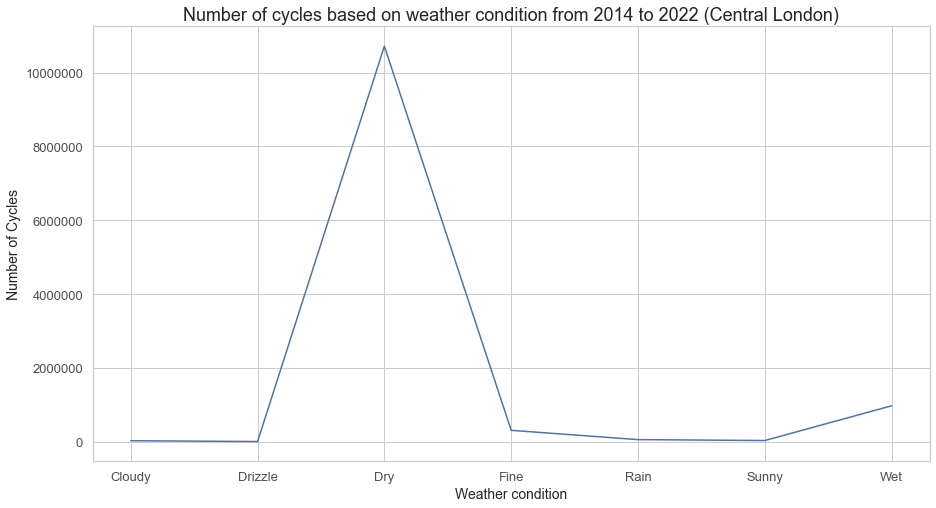

In [60]:
# Visualise relationship between number of cyclists and weather.
central_weather = subset_c_london_updated.groupby(['Weather']).sum().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.lineplot(data = central_weather, x = 'Weather', y = 'Total cycles')\
.set(title = 'Number of cycles based on weather condition from 2014 to 2022 (Central London)', xlabel = 'Weather condition',
     ylabel = 'Number of Cycles')
plt.ticklabel_format(style='plain', axis='y')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

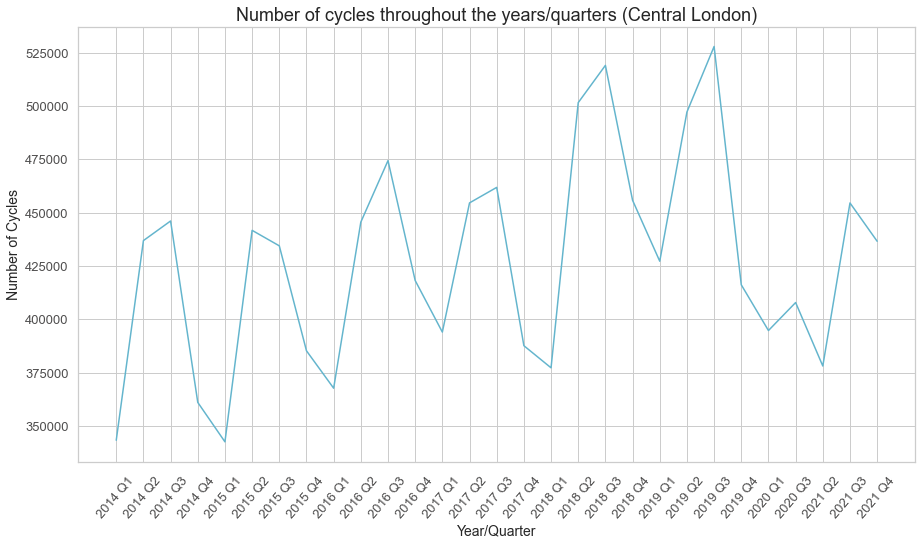

In [61]:
# Visualise relationship between number of cyclists and date (quarters of year).
central_date = subset_c_london.groupby(['Survey Year/Quarter']).sum().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.lineplot(data = central_date, x = 'Survey Year/Quarter', y = 'Total cycles', color = 'c')\
.set(title = 'Number of cycles throughout the years/quarters (Central London)', xlabel = 'Year/Quarter',
     ylabel = 'Number of Cycles')
plt.xticks(rotation = 50)

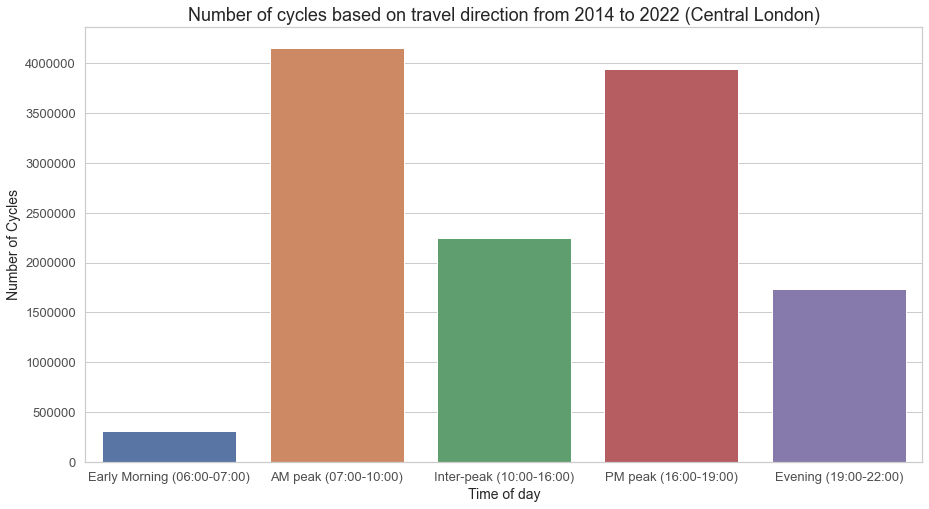

In [62]:
# Visualise relationship between number of cyclists and time of day.
central_tod = subset_c_london.groupby(['Period']).sum().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.barplot(data = central_tod, x = 'Period', y = 'Total cycles', order = ['Early Morning (06:00-07:00)',
'AM peak (07:00-10:00)', 'Inter-peak (10:00-16:00)', 'PM peak (16:00-19:00)', 'Evening (19:00-22:00)'])\
.set(title = 'Number of cycles based on travel direction from 2014 to 2022 (Central London)', xlabel = 'Time of day',
     ylabel = 'Number of Cycles')
plt.ticklabel_format(style='plain', axis='y')

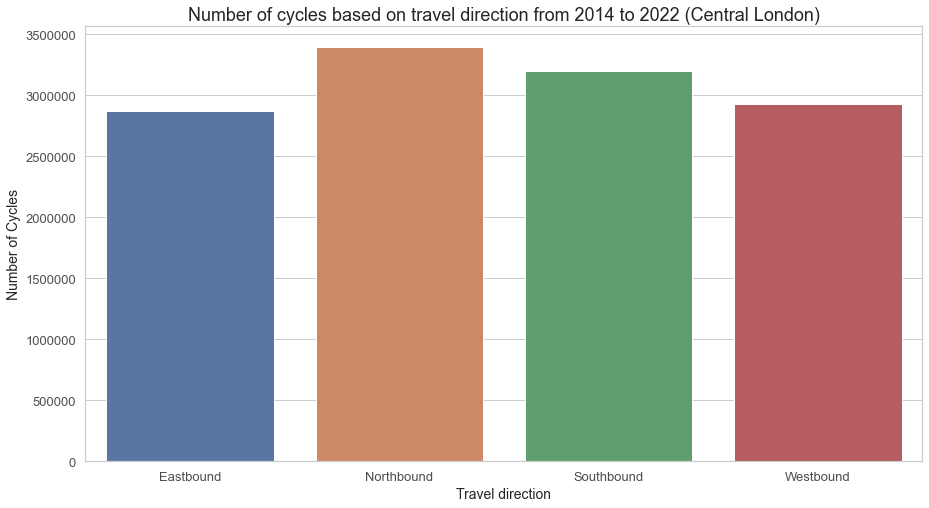

In [63]:
# Visualise relationhip between number of cyclists and direction of travel.
central_dir = subset_c_london.groupby(['Direction']).sum().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.barplot(data = central_dir, x = 'Direction', y = 'Total cycles')\
.set(title = 'Number of cycles based on travel direction from 2014 to 2022 (Central London)', xlabel = 'Travel direction',
     ylabel = 'Number of Cycles')
plt.ticklabel_format(style='plain', axis='y')

### Inner London data set: visualisations

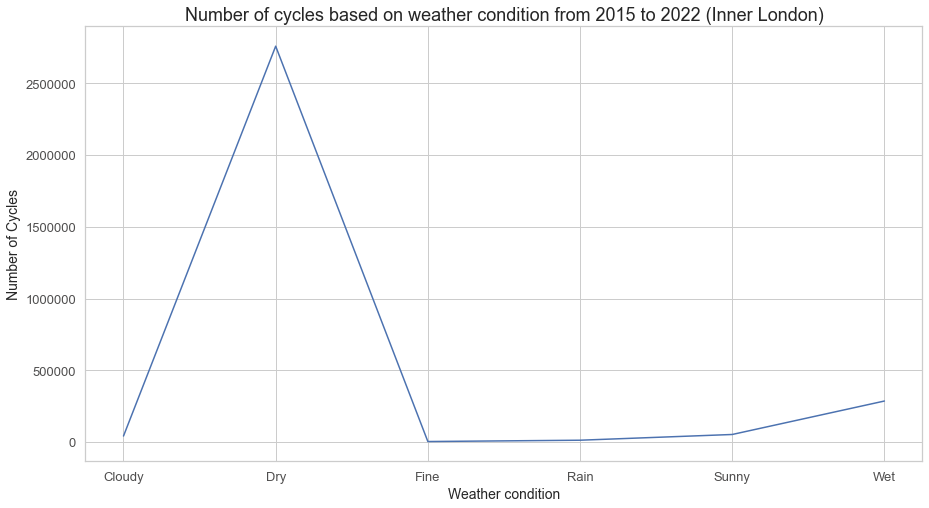

In [64]:
# Visualise relationship between number of cyclists and weather.
inner_weather = subset_i_london_updated.groupby(['Weather']).sum().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.lineplot(data = inner_weather, x = 'Weather', y = 'Total cycles')\
.set(title = 'Number of cycles based on weather condition from 2015 to 2022 (Inner London)', xlabel = 'Weather condition',
     ylabel = 'Number of Cycles')
plt.ticklabel_format(style='plain', axis='y')

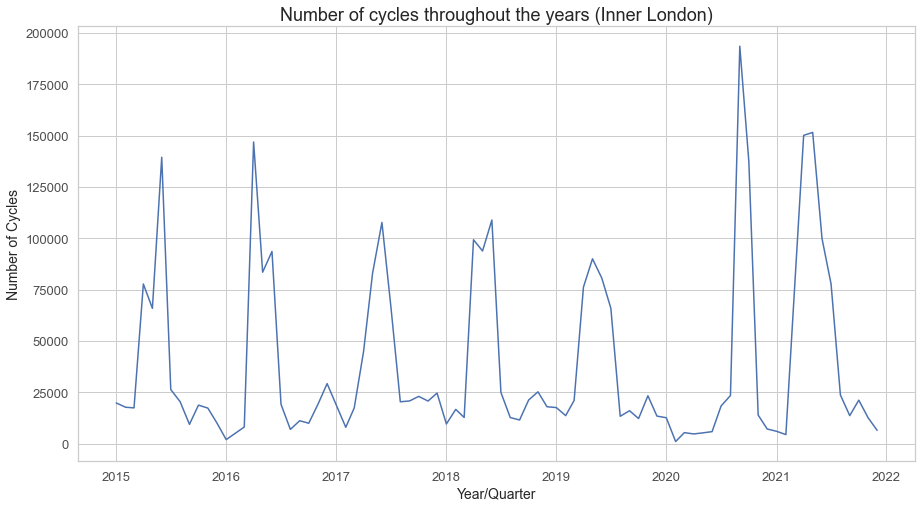

In [65]:
# Visualise relationship between number of cyclists and date.
inner_date = subset_i_london.groupby(['Survey date (Y/M)']).sum().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.lineplot(data = inner_date, x = 'Survey date (Y/M)', y = 'Total cycles')\
.set(title = 'Number of cycles throughout the years (Inner London)', xlabel = 'Year/Quarter',
     ylabel = 'Number of Cycles')

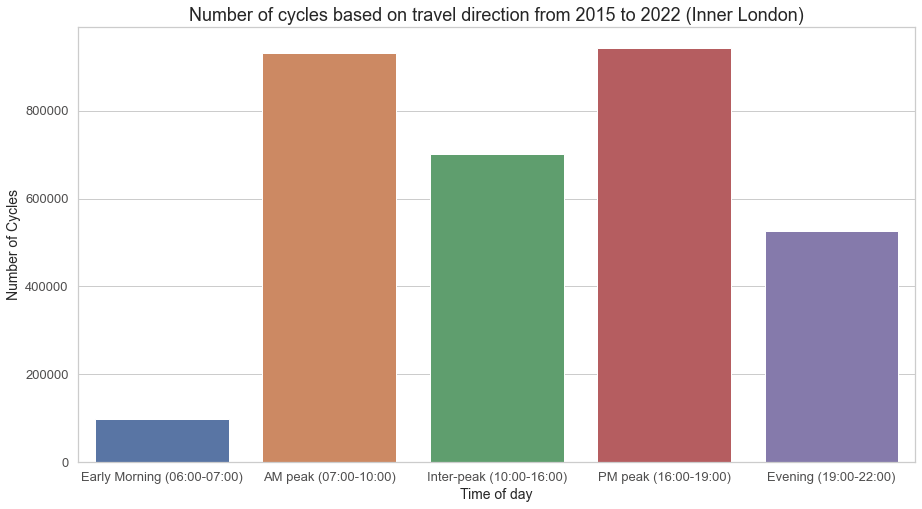

In [66]:
# Visualise relationship between number of cyclists and time of day.
inner_tod = subset_i_london.groupby(['Period']).sum().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.barplot(data = inner_tod, x = 'Period', y = 'Total cycles', order = ['Early Morning (06:00-07:00)',
'AM peak (07:00-10:00)', 'Inter-peak (10:00-16:00)', 'PM peak (16:00-19:00)', 'Evening (19:00-22:00)'])\
.set(title = 'Number of cycles based on travel direction from 2015 to 2022 (Inner London)', xlabel = 'Time of day',
     ylabel = 'Number of Cycles')
plt.ticklabel_format(style='plain', axis='y')

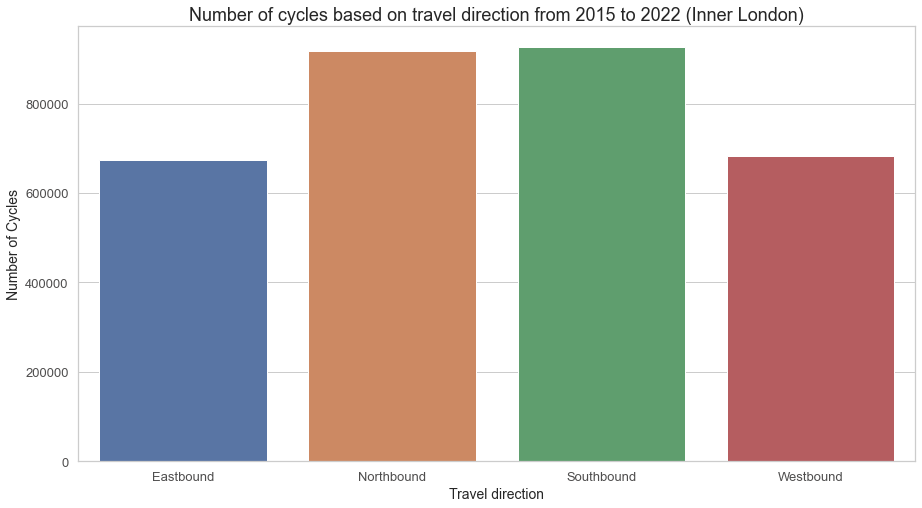

In [67]:
# Visualise relationhip between number of cyclists and direction of travel.
inner_dir = subset_i_london.groupby(['Direction']).sum().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.barplot(data = inner_dir, x = 'Direction', y = 'Total cycles')\
.set(title = 'Number of cycles based on travel direction from 2015 to 2022 (Inner London)', xlabel = 'Travel direction',
     ylabel = 'Number of Cycles')
plt.ticklabel_format(style='plain', axis='y')

### Outer London data set: visualisations

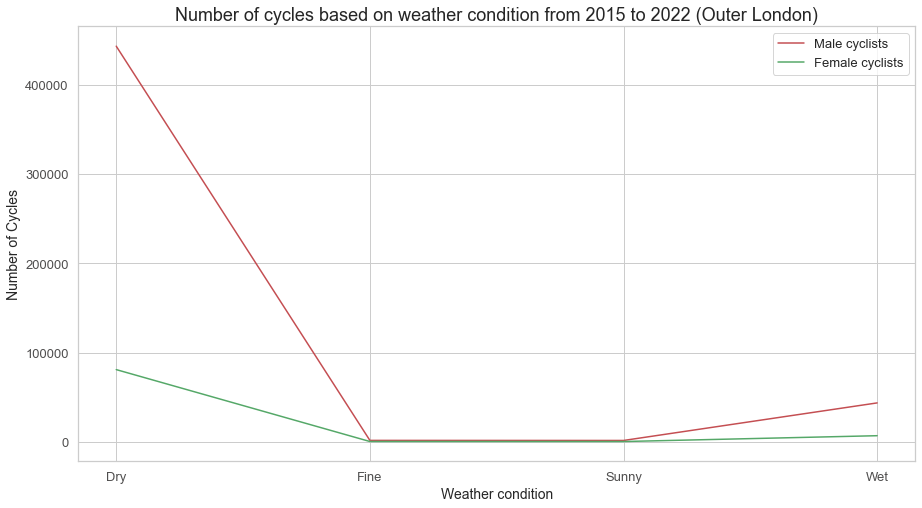

In [68]:
# Visualise relationship between number of cyclists (male vs. female) and weather.
outer_weather = subset_o_london_updated.groupby(['Weather']).sum().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.lineplot(data = outer_weather, x = 'Weather', y = 'Number of male cycles', color = 'r')
ax1 = sns.lineplot(data = outer_weather, x = 'Weather', y = 'Number of female cycles', color = 'g')\
.set(title = 'Number of cycles based on weather condition from 2015 to 2022 (Outer London)', xlabel = 'Weather condition',
     ylabel = 'Number of Cycles')
plt.legend(labels = ['Male cyclists', 'Female cyclists'])

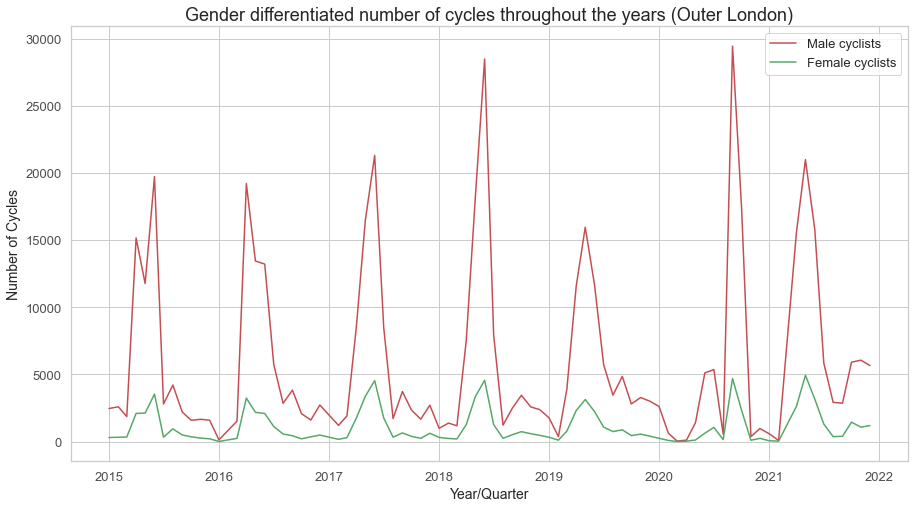

In [69]:
# Visualilse relationhip between number of cyclists (male vs. female) and date.
outer_date = subset_o_london.groupby(['Survey date (Y/M)']).sum().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.lineplot(data = outer_date, x = 'Survey date (Y/M)', y = 'Number of male cycles', color = 'r')
ax1 = sns.lineplot(data = outer_date, x = 'Survey date (Y/M)', y = 'Number of female cycles', color = 'g')\
.set(title = 'Gender differentiated number of cycles throughout the years (Outer London)', xlabel = 'Year/Quarter',
     ylabel = 'Number of Cycles')
plt.legend(labels = ['Male cyclists', 'Female cyclists'])

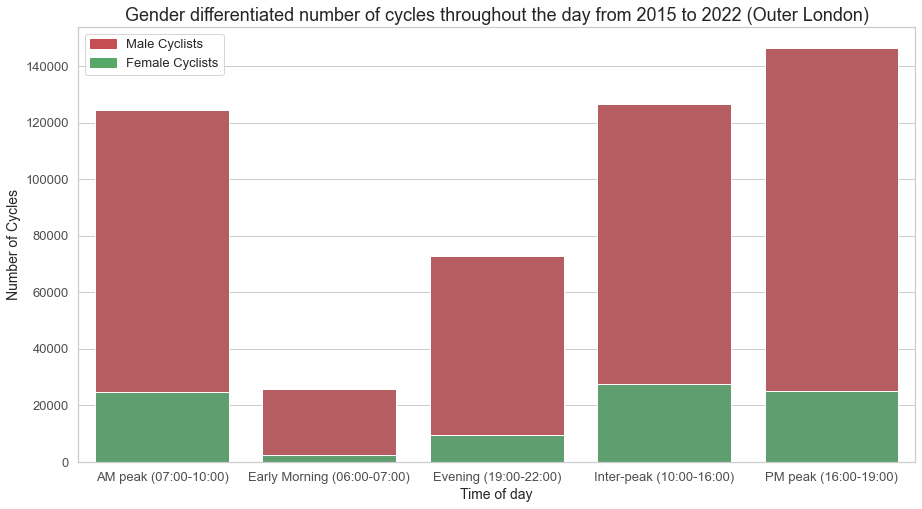

In [70]:
# Visualise relationship between number of cyclists (male vs. female) and time of day.
outer_tod = subset_o_london.groupby(['Period']).sum().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.barplot(data = outer_tod, x = 'Period', y = 'Number of male cycles', color = 'r')
ax1 = sns.barplot(data = outer_tod, x = 'Period', y = 'Number of female cycles', color = 'g')\
.set(title = 'Gender differentiated number of cycles throughout the day from 2015 to 2022 (Outer London)', 
     xlabel = 'Time of day', ylabel = 'Number of Cycles')
plt.ticklabel_format(style='plain', axis='y')
top_bar = mpatches.Patch(color = 'r', label = 'Male Cyclists')
bottom_bar = mpatches.Patch(color = 'g', label = 'Female Cyclists')
plt.legend(handles = [top_bar, bottom_bar])

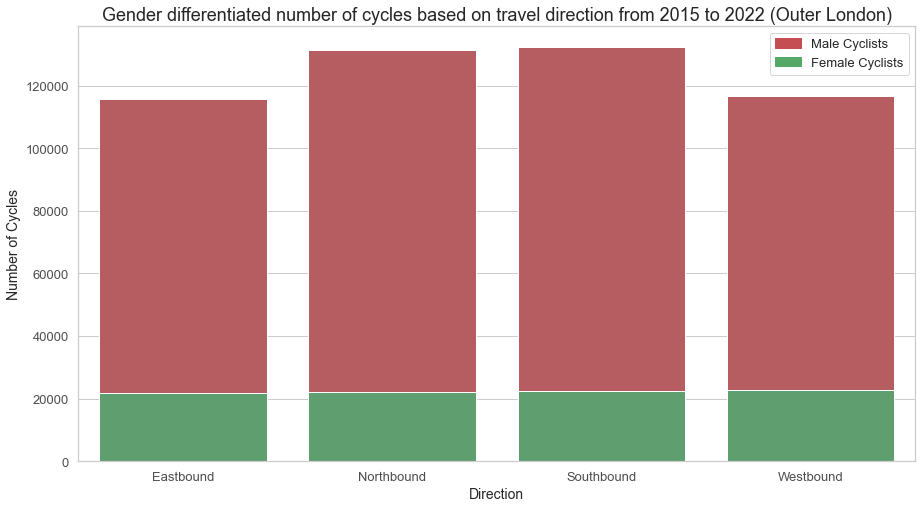

In [71]:
# Visualise relationship between number of cyclists (male vs. female) and direction of travel.
outer_dir = subset_o_london.groupby(['Direction']).sum().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.barplot(data = outer_dir, x = 'Direction', y = 'Number of male cycles', color = 'r')
ax1 = sns.barplot(data = outer_dir, x = 'Direction', y = 'Number of female cycles', color = 'g')\
.set(title = 'Gender differentiated number of cycles based on travel direction from 2015 to 2022 (Outer London)', 
     xlabel = 'Direction', ylabel = 'Number of Cycles')
plt.ticklabel_format(style='plain', axis='y')
top_bar = mpatches.Patch(color = 'r', label = 'Male Cyclists')
bottom_bar = mpatches.Patch(color = 'g', label = 'Female Cyclists')
plt.legend(handles = [top_bar, bottom_bar])

## ***Extra (visualisation)***

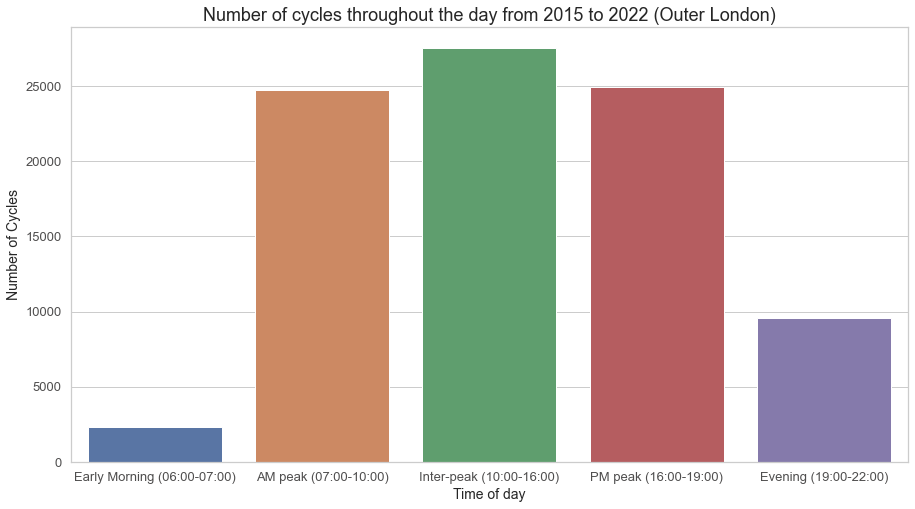

In [72]:
# Outer London - Visualise relationship between number of cyclists and time of day.
outer_tod = subset_o_london.groupby(['Period']).sum().reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax1 = sns.barplot(data = outer_tod, x = 'Period', y = 'Number of female cycles', order = ['Early Morning (06:00-07:00)',
'AM peak (07:00-10:00)', 'Inter-peak (10:00-16:00)', 'PM peak (16:00-19:00)', 'Evening (19:00-22:00)'])\
.set(title = 'Number of cycles throughout the day from 2015 to 2022 (Outer London)', 
     xlabel = 'Time of day', ylabel = 'Number of Cycles')
plt.ticklabel_format(style='plain', axis='y')

## 4. Time-series Analysis & Forecast

### Central London

In [73]:
# Use subset_c_london data frame and set date as index.
c_ldn = subset_c_london.set_index('Survey date')

print(c_ldn.info())
c_ldn.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 743061 entries, 2014-01-24 to 2021-12-21
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Survey Year/Quarter  743061 non-null  object 
 1   Location             743061 non-null  object 
 2   Weather              743061 non-null  object 
 3   Time                 743061 non-null  object 
 4   Period               743061 non-null  object 
 5   Direction            743061 non-null  object 
 6   Total cycles         743061 non-null  float64
dtypes: float64(1), object(6)
memory usage: 45.4+ MB
None


Survey Year/Quarter                            Location Weather  \
Survey date                                                                   
2014-01-24             2014 Q1   Millbank (south of Thorney Street)     Dry   
2014-01-24             2014 Q1   Millbank (south of Thorney Street)     Dry   
2014-01-24             2014 Q1   Millbank (south of Thorney Street)     Dry   
2014-01-24             2014 Q1   Millbank (south of Thorney Street)     Dry   
2014-01-24             2014 Q1   Millbank (south of Thorney Street)     Dry   

                    Time                       Period   Direction  \
Survey date                                                         
2014-01-24   0600 - 0615  Early Morning (06:00-07:00)  Northbound   
2014-01-24   0615 - 0630  Early Morning (06:00-07:00)  Northbound   
2014-01-24   0630 - 0645  Early Morning (06:00-07:00)  Northbound   
2014-01-24   0645 - 0700  Early Morning (06:00-07:00)  Northbound   
2014-01-24   0700 - 0715        AM peak (07:00-10:00)  Northbound   

             Total cycles  
Survey date                
2014-01-24           0.00  
2014-01-24          15.00  
2014-01-24          35.00  
2014-01-24          61.00  
2014-01-24          73.00

In [74]:
# Subset data frame to include only relevant rows.
c_ldn_clean = c_ldn[['Total cycles']].sort_index()

# Aggregate index (sum same dates).
c_ldn_clean = c_ldn_clean.sum(axis = 0, level = 0)

c_ldn_clean

Total cycles
Survey date              
2014-01-04        9237.00
2014-01-05         603.00
2014-01-07       10379.00
2014-01-08        1431.00
2014-01-10        2750.00
...                   ...
2021-12-21         310.00
2021-12-22         247.00
2021-12-23         137.00
2021-12-24         215.00
2021-12-30         220.00

[1596 rows x 1 columns]

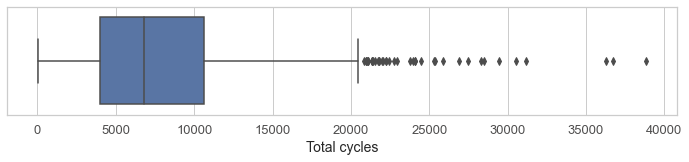

In [75]:
# Determine outliers.
fig = plt.subplots(figsize = (12, 2))
ax = sns.boxplot(x = c_ldn_clean['Total cycles'], whis = 1.5)

In [76]:
# Remove outliers.
cols = ['Total cycles']

# Calculate quantiles and IQR.
Q1 = c_ldn_clean[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100).
Q3 = c_ldn_clean[cols].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

# Return a boolean array of the rows with (any) non-outlier column values.
condition = ~((c_ldn_clean[cols] < (Q1 - 1.5 * IQR)) | \
              (c_ldn_clean[cols] > (Q3 + 1.5 * IQR))).any(axis = 1)

# Filter our dataframe based on condition.
c_ldn_non_outlier = c_ldn_clean[condition]
c_ldn_non_outlier.shape

Total cycles   6679.50
dtype: float64


(1557, 1)

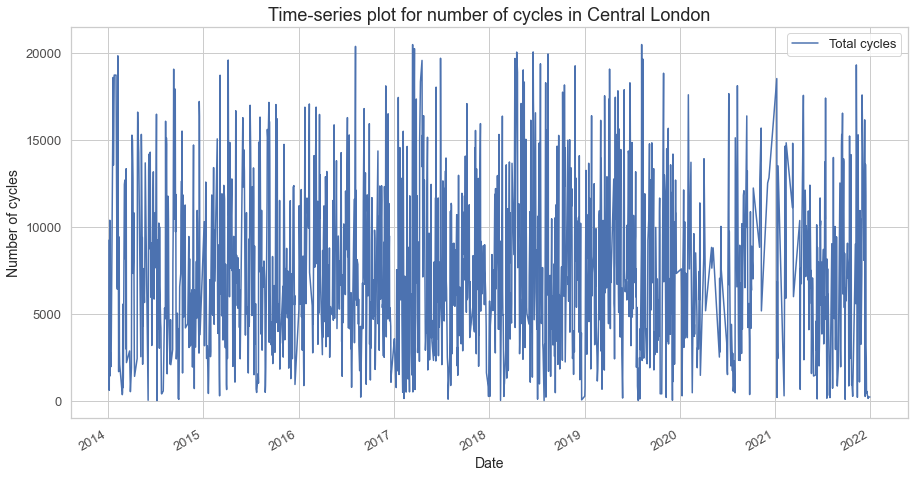

In [77]:
# Plotting the time series data.
c_ldn_non_outlier.plot(figsize = (15, 8))
plt.legend(loc = 'best')
plt.title('Time-series plot for number of cycles in Central London')
plt.xlabel('Date')
plt.ylabel('Number of cycles')
plt.show(block = False)

In [78]:
# Resampling dataset: 
c_ldn_res = c_ldn_non_outlier.resample('M').mean()

# view DataFrame.
c_ldn_res

Total cycles
Survey date              
2014-01-31        9593.90
2014-02-28        5492.38
2014-03-31        6025.64
2014-04-30       10455.08
2014-05-31        8076.75
...                   ...
2021-08-31        5607.89
2021-09-30        8746.48
2021-10-31        6575.00
2021-11-30        8296.21
2021-12-31        4763.50

[96 rows x 1 columns]

In [79]:
# Dropping any missing values: 
c_ldn_res.dropna(inplace = True)
c_ldn_res.isna().sum()

Total cycles    0
dtype: int64

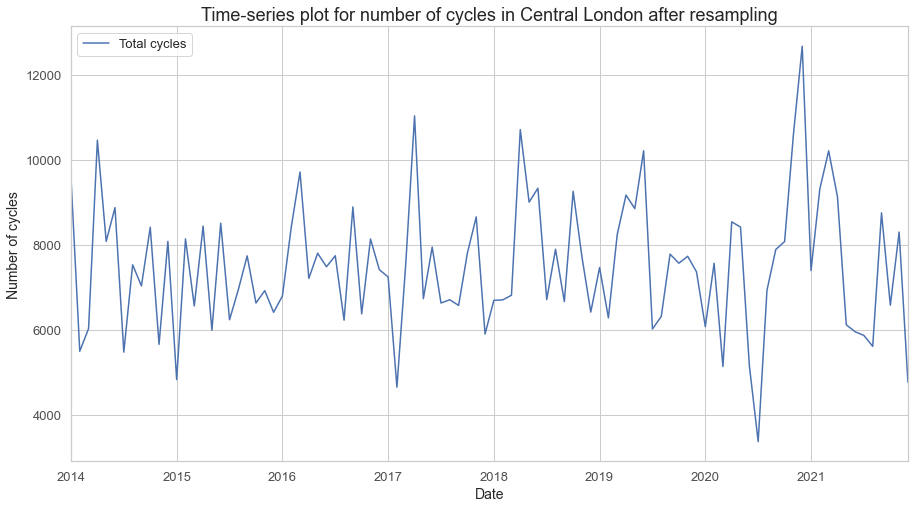

In [80]:
# Plotting the time series data again.
c_ldn_res.plot(figsize = (15, 8))
plt.legend(loc = 'best')
plt.title('Time-series plot for number of cycles in Central London after resampling')
plt.xlabel('Date')
plt.ylabel('Number of cycles')
plt.show(block = False)

### Forecast - Central London

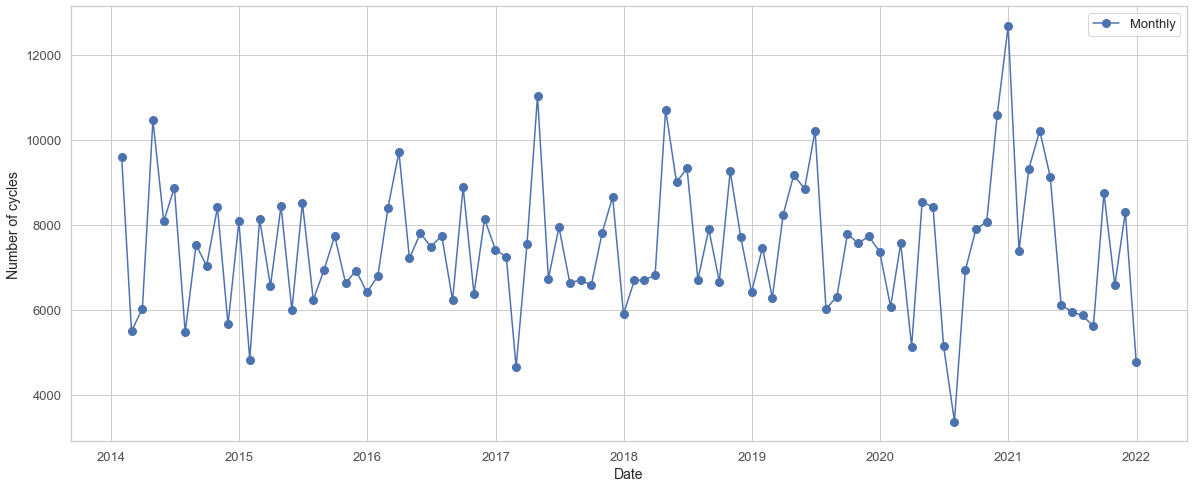

In [81]:
# Define input and visualise.
df = c_ldn_res

y = df['Total cycles']

fig, ax = plt.subplots(figsize = (20, 8))
ax.plot(y, marker = 'o', markersize = 8, linestyle = '-', label = 'Monthly')
ax.set_ylabel('Number of cycles')
ax.set_xlabel('Date')
ax.legend()

#### Decomposing the data

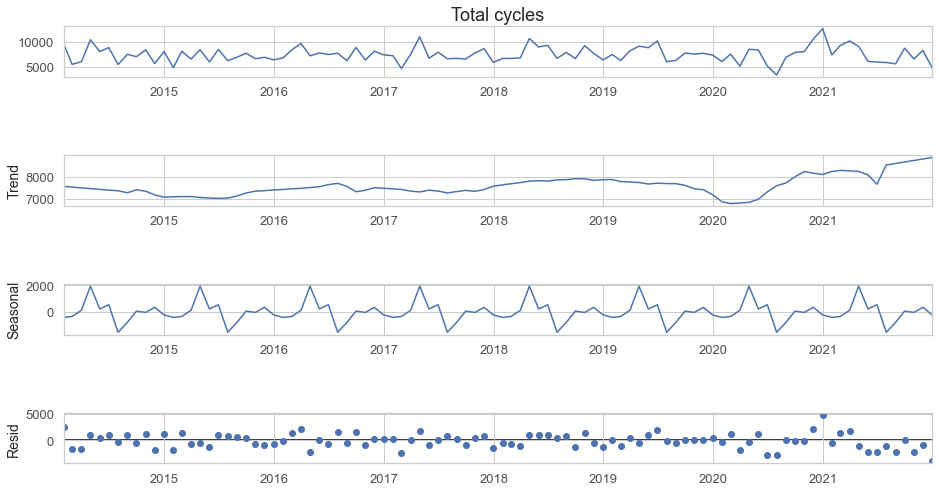

In [82]:
### Decompose the data.
# Visualise to show seasonal_decompose.
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model = 'additive', extrapolate_trend = 'freq')
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)
    plt.show()
    
seasonal_decompose(y)

In [83]:
### After looking at the four pieces decomposed graphs, we can tell that our sales dataset has an overall 
### increasing trend as well as a yearly seasonality.

#### Check for Stationarity

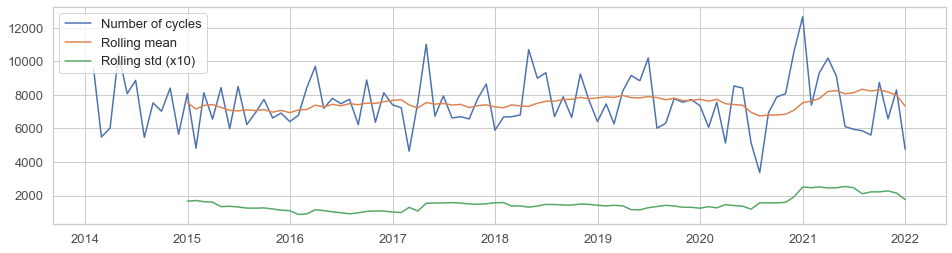

In [84]:
### Plot for Rolling Statistic for testing Stationarity.
def test_stationarity(timeseries, title):
    
    # Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window = 12).mean() 
    rolstd = pd.Series(timeseries).rolling(window = 12).std()
    
    fig, ax = plt.subplots(figsize = (16, 4))
    ax.plot(timeseries, label = 'Number of cycles')
    ax.plot(rolmean, label = 'Rolling mean');
    ax.plot(rolstd, label = 'Rolling std (x10)');
    ax.legend()
    
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y, 'Raw data')

In [85]:
### Both the mean and standard deviation for stationary data does not change much over time.

In [86]:
# Augmented Dickey-Fuller Test
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag = 'AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v < dftest[0] else '', 100-int(k[:-1])))
        
ADF_test(y, 'Raw data')

 > Is the Raw data stationary ?
Test statistic = -5.042
P-value = 0.000
Critical values :
	1%: -3.5078527246648834 - The data is  stationary with 99% confidence
	5%: -2.895382030636155 - The data is  stationary with 95% confidence
	10%: -2.584823877658872 - The data is  stationary with 90% confidence


In [87]:
### We can confirm that the data is stationary.

#### Create training and testing data sets

In [88]:
y_to_train = y[:'2019-12-31'] # Dataset to train.
y_to_val = y['2020-01-01':] # Dataset to test.  
predict_date = len(y) - len(y[:'2020-01-01']) # The number of data points for the test set.

#### SARIMA (Seasonal autoregressive integrated moving average)

In [89]:
### Define SARIMA model.

# Use AIC evaluation metric for Grid-search to find parameters (pick one with lowest AIC value).

def sarima_grid_search(y, seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal
                    
                  # print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))
    
sarima_grid_search(y, 12)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:1227.252906473756


In [90]:
# Use above parameters to fit the model.
def sarima_eva(y, order, seasonal_order, seasonal_period, pred_date, y_to_test):
    # Fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                    order = order,
                                    seasonal_order = seasonal_order,
                                    enforce_stationarity = False,
                                    enforce_invertibility = False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize = (25, 12))
    plt.show()
    
    # The dynamic = False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start = pd.to_datetime(pred_date), dynamic = False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length = {} and dynamic = False {}'.format(seasonal_period, round(np.sqrt(mse), 2)))

    ax = y.plot(label = 'Observed')
    y_forecasted.plot(ax = ax, label = 'One-step ahead Forecast', alpha = 0.7, figsize = (20, 8))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start = pd.to_datetime(pred_date), dynamic = True, full_results = True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length = {} and dynamic = True {}'.format(seasonal_period, round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label = 'Observed')
    y_forecasted_dynamic.plot(label = 'Dynamic Forecast', ax = ax, figsize = (20, 8))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color = 'k', alpha = 0.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1679      0.133      1.267      0.205      -0.092       0.428
ma.L1         -0.9990      1.013     -0.986      0.324      -2.985       0.987
ar.S.L12      -0.0825      0.202     -0.409      0.682      -0.478       0.313
ma.S.L12      -0.7879      0.189     -4.175      0.000      -1.158      -0.418
sigma2      2.377e+06   2.42e+06      0.981      0.327   -2.37e+06    7.13e+06


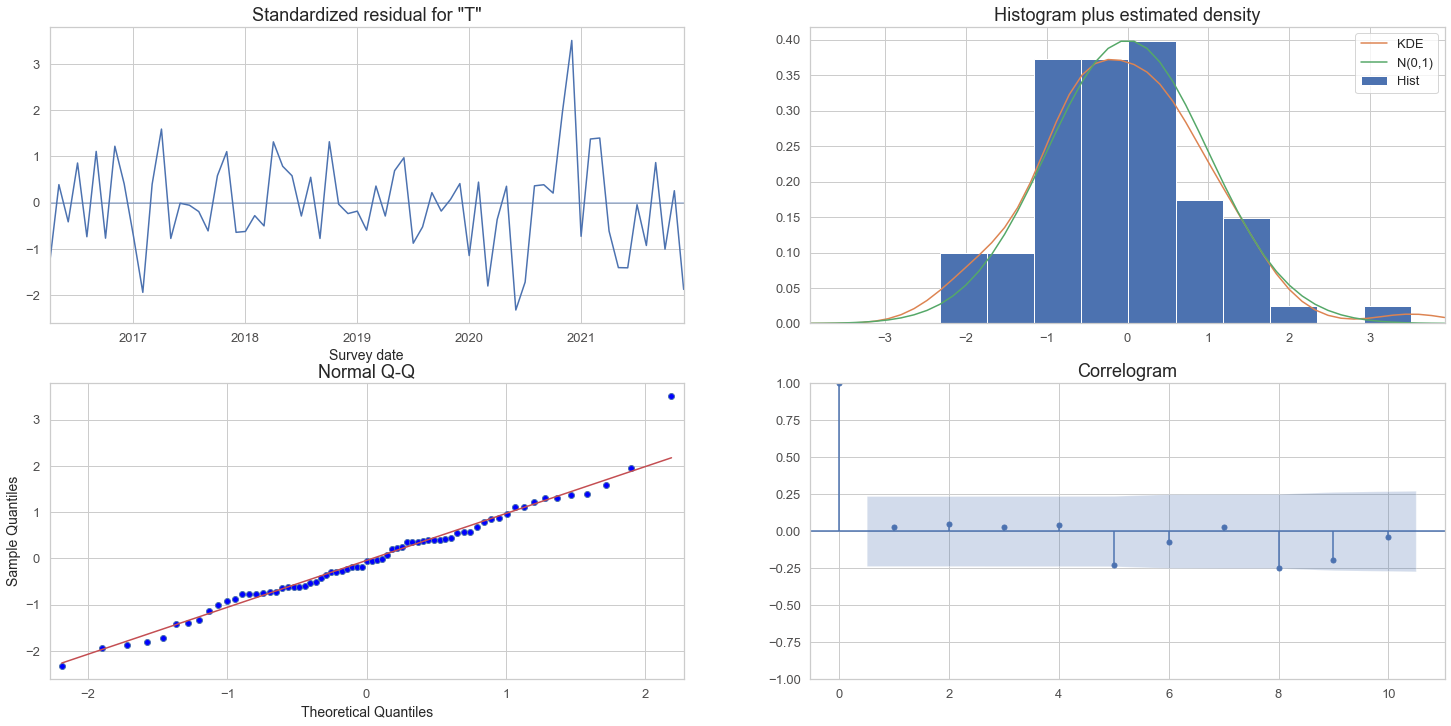

The Root Mean Squared Error of SARIMA with season_length = 12 and dynamic = False 2149.79


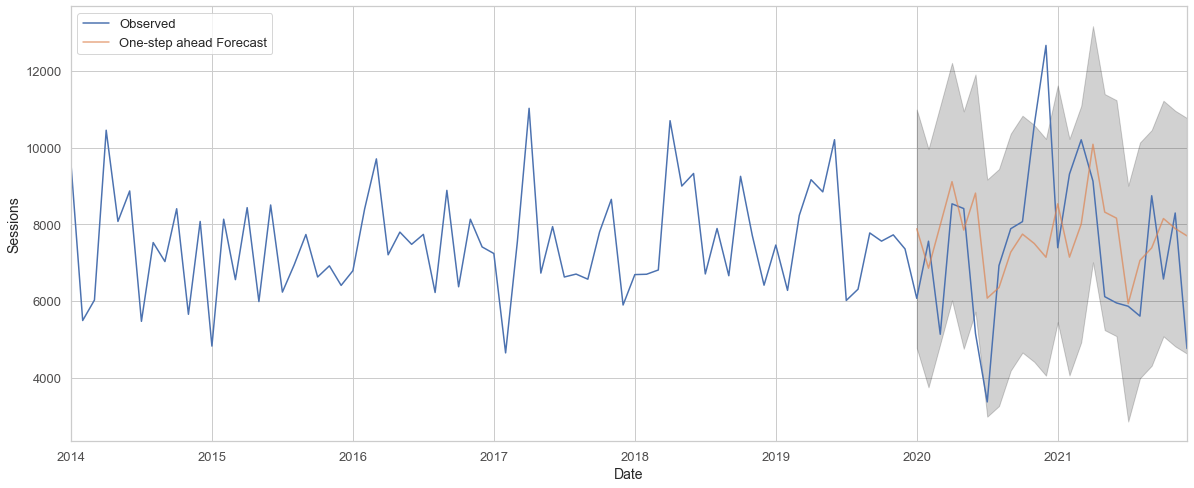

The Root Mean Squared Error of SARIMA with season_length = 12 and dynamic = True 2230.9


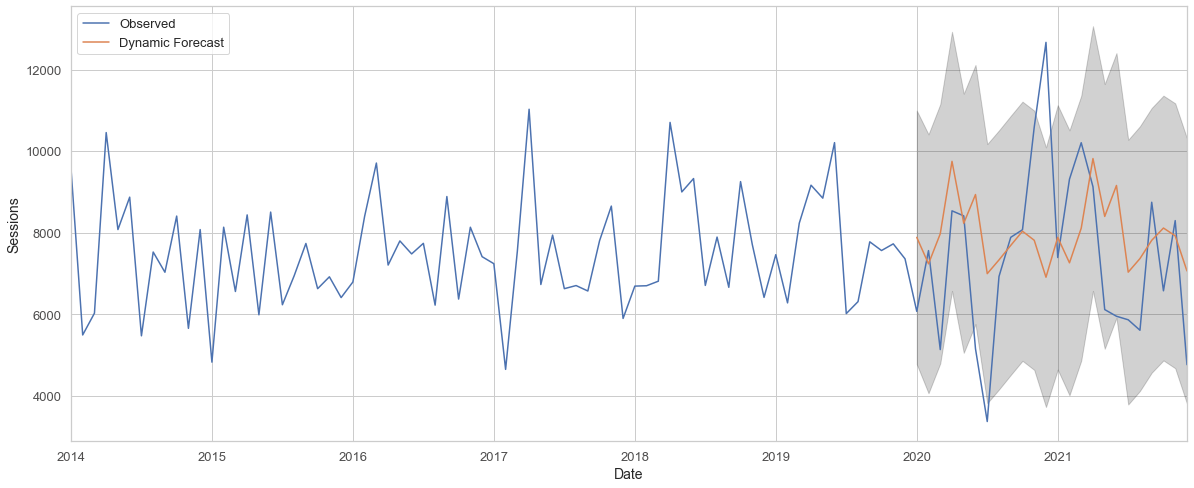

In [91]:
# View results.
model = sarima_eva(y, (1, 1, 1), (1, 1, 1, 12), 12, '2020-01-31', y_to_val)

In [92]:
### By looking at the residuals over time, find out if the residuals are normally distributed, ordered distribution of residuals
### and autocorrelation plot, we can conclude that this model’s residuals are near normally distributed. This indicates we have 
### found a well-fit model suitable for our dataset.

#### Making predictions

In [93]:
# Perform forecasting.
def forecast(model, predict_steps, y):
    
    pred_uc = model.get_forecast(steps = predict_steps)

    # SARIMAXResults.conf_int, can change alpha, the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label = 'Observed', figsize = (20, 10))
    print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax = ax, label = 'Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color = 'k', alpha = 0.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)
    ax.set_title('Predicted number of cycles for Central London')

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date', 'Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date', 'Lower Bound', 'Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on = 'Date')
    
    return (final_table)

2022-01-31   6819.98827444
2022-02-28   7330.43810110
2022-03-31   7638.46666968
2022-04-30   9291.63980941
2022-05-31   7908.46576832
                  ...     
2023-08-31   6783.91521210
2023-09-30   7892.98572141
2023-10-31   7667.30697386
2023-11-30   8350.49789081
2023-12-31   7449.56979831
Freq: M, Name: predicted_mean, Length: 24, dtype: float64


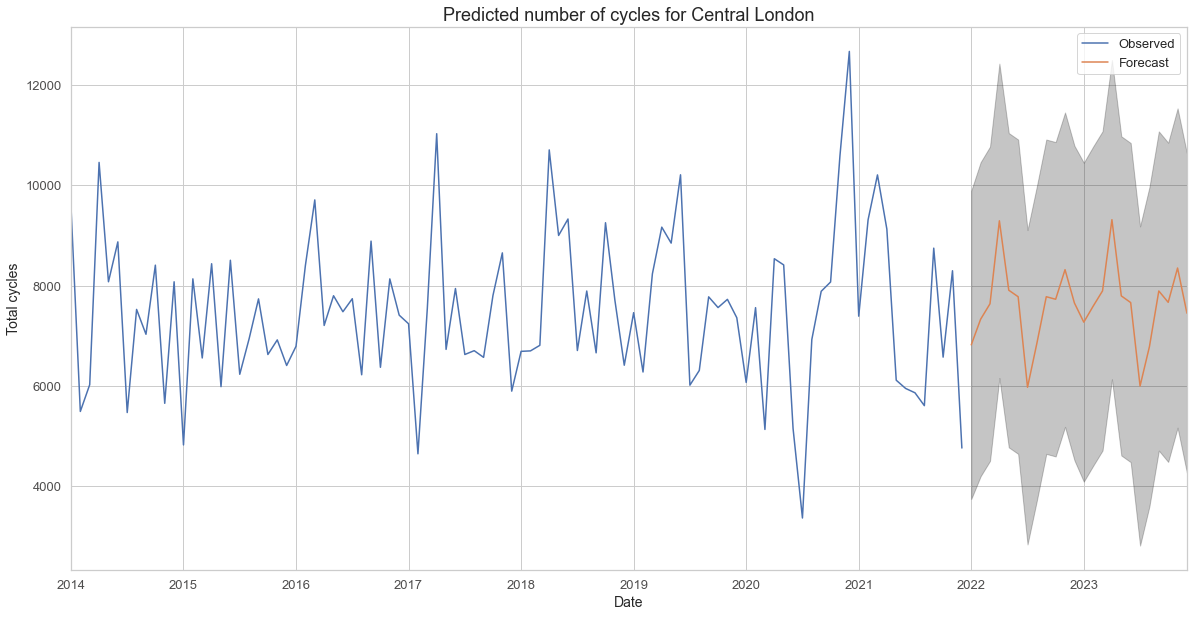

Date  Predicted_Mean   Lower Bound    Upper Bound
0  2022-01-31   6819.98827444 3747.97951470  9891.99703417
1  2022-02-28   7330.43810110 4201.68159470 10459.19460750
2  2022-03-31   7638.46666968 4506.43552150 10770.49781787
3  2022-04-30   9291.63980941 6159.75021403 12423.52940480
4  2022-05-31   7908.46576832 4776.74349094 11040.18804569
..        ...             ...           ...            ...
19 2023-08-31   6783.91521210 3603.83932561  9963.99109860
20 2023-09-30   7892.98572141 4712.79065793 11073.18078489
21 2023-10-31   7667.30697386 4486.86060509 10847.75334264
22 2023-11-30   8350.49789081 5169.41084149 11531.58494012
23 2023-12-31   7449.56979831 4266.79954038 10632.34005623

[24 rows x 4 columns]

In [94]:
# View results (predictions for next 24 months).
final_table = forecast(model, 24, y)
final_table

2022-01-31   6819.98827444
2022-02-28   7330.43810110
2022-03-31   7638.46666968
2022-04-30   9291.63980941
2022-05-31   7908.46576832
                  ...     
2023-08-31   6783.91521210
2023-09-30   7892.98572141
2023-10-31   7667.30697386
2023-11-30   8350.49789081
2023-12-31   7449.56979831
Freq: M, Name: predicted_mean, Length: 24, dtype: float64


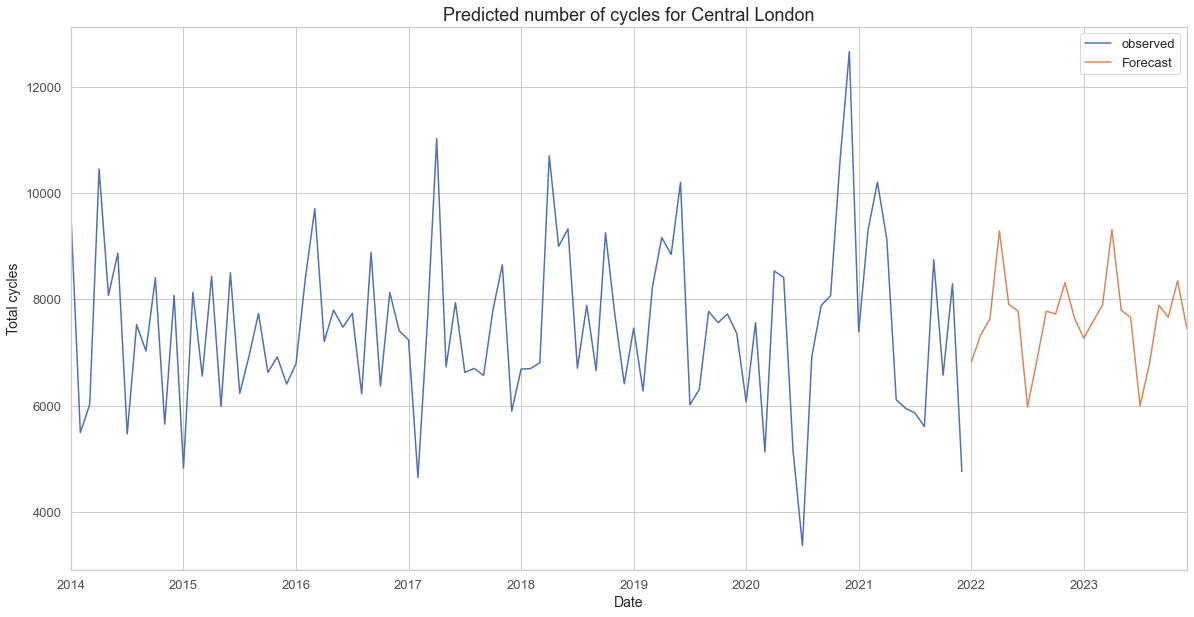

In [95]:
### Graphs without the confident interval.
pred_uc = model.get_forecast(steps = 24)
ax = y.plot(label = 'observed', figsize = (20, 10))
print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax = ax, label = 'Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)
ax.set_title('Predicted number of cycles for Central London')

plt.legend()
plt.show()

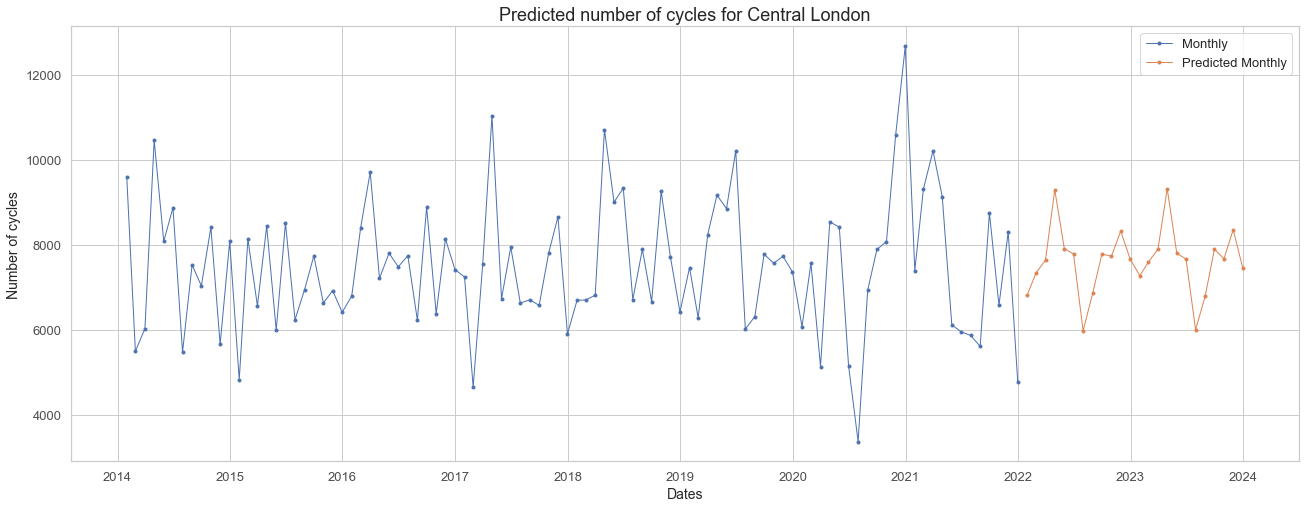

In [96]:
### Graphs show only the perdiected period.
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize = (22, 8))
ax.plot(y, marker = '.', linestyle = '-', linewidth = 1, label = 'Monthly')
ax.plot(final_table.Predicted_Mean, marker = '.', linestyle = '-', linewidth = 1, label = 'Predicted Monthly')
ax.set_ylabel('Number of cycles')
ax.set_xlabel('Dates')
ax.set_title('Predicted number of cycles for Central London')
ax.legend();

### Inner London

In [97]:
# Use subset_i_london data frame and set date as index.
i_ldn = subset_i_london.set_index('Survey date')

print(i_ldn.info())
i_ldn.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 516536 entries, 2015-05-20 to 2021-05-26
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Location           516536 non-null  object        
 1   Weather            516536 non-null  object        
 2   Time               516536 non-null  object        
 3   Period             516536 non-null  object        
 4   Direction          516536 non-null  object        
 5   Total cycles       516536 non-null  float64       
 6   Survey date (Y/M)  516536 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 31.5+ MB
None


Location Weather         Time                       Period  \
Survey date                                                                 
2015-05-20   Grove Road     Dry  0600 - 0615  Early Morning (06:00-07:00)   
2015-05-20   Grove Road     Dry  0615 - 0630  Early Morning (06:00-07:00)   
2015-05-20   Grove Road     Dry  0630 - 0645  Early Morning (06:00-07:00)   
2015-05-20   Grove Road     Dry  0645 - 0700  Early Morning (06:00-07:00)   
2015-05-20   Grove Road     Dry  0700 - 0715        AM peak (07:00-10:00)   

              Direction  Total cycles Survey date (Y/M)  
Survey date                                              
2015-05-20   Northbound    1.00000000        2015-05-01  
2015-05-20   Northbound    2.00000000        2015-05-01  
2015-05-20   Northbound    2.00000000        2015-05-01  
2015-05-20   Northbound    4.00000000        2015-05-01  
2015-05-20   Northbound    4.00000000        2015-05-01

In [98]:
# Subset data frame to include only relevant rows.
i_ldn_clean = i_ldn[['Total cycles']].sort_index()

# Aggregate index (sum same dates).
i_ldn_clean = i_ldn_clean.sum(axis = 0, level = 0)

i_ldn_clean

Total cycles
Survey date               
2015-01-05    608.00000000
2015-01-06   7556.00000000
2015-01-07  11678.00000000
2015-02-06   5714.00000000
2015-02-07  12040.00000000
...                    ...
2021-10-06  15541.00000000
2021-11-05   4058.00000000
2021-11-06   8562.00000000
2021-12-05   5066.00000000
2021-12-07   1432.00000000

[463 rows x 1 columns]

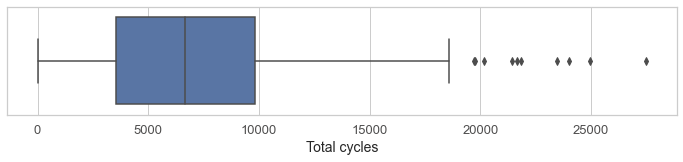

In [99]:
# Determine outliers.
fig = plt.subplots(figsize = (12, 2))
ax = sns.boxplot(x = i_ldn_clean['Total cycles'], whis = 1.5)

In [100]:
# Remove outliers.
cols = ['Total cycles']

# Calculate quantiles and IQR.
Q1 = i_ldn_clean[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100).
Q3 = i_ldn_clean[cols].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

# Return a boolean array of the rows with (any) non-outlier column values.
condition = ~((i_ldn_clean[cols] < (Q1 - 1.5 * IQR)) | \
              (i_ldn_clean[cols] > (Q3 + 1.5 * IQR))).any(axis = 1)

# Filter our dataframe based on condition.
i_ldn_non_outlier = i_ldn_clean[condition]
i_ldn_non_outlier.shape

Total cycles   6257.00000000
dtype: float64


(453, 1)

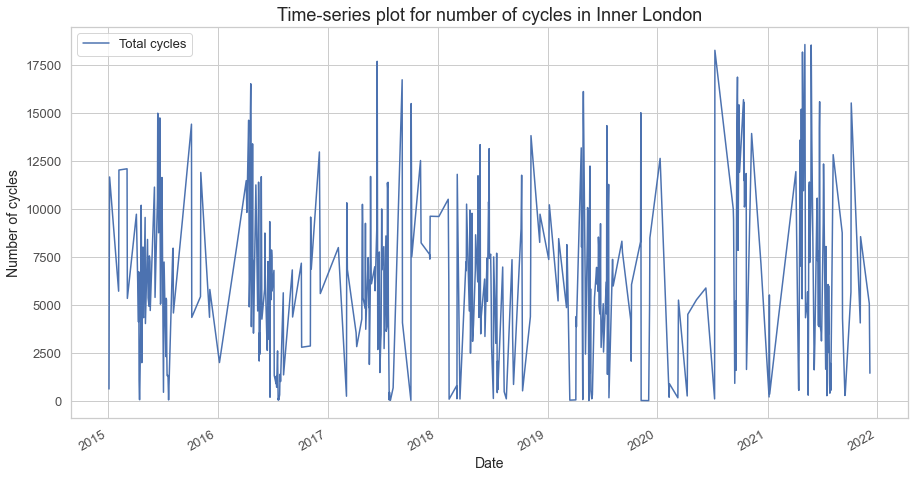

In [101]:
# Plotting the time series data.
i_ldn_non_outlier.plot(figsize = (15, 8))
plt.legend(loc = 'best')
plt.title('Time-series plot for number of cycles in Inner London')
plt.xlabel('Date')
plt.ylabel('Number of cycles')
plt.show(block = False)

In [102]:
# Resampling dataset: 
i_ldn_res = i_ldn_non_outlier.resample('M').mean()

# view DataFrame.
i_ldn_res

Total cycles
Survey date               
2015-01-31   6614.00000000
2015-02-28   8877.00000000
2015-03-31   8721.00000000
2015-04-30   5184.00000000
2015-05-31   6591.00000000
...                    ...
2021-08-31  11861.50000000
2021-09-30   3417.75000000
2021-10-31  10605.50000000
2021-11-30   6310.00000000
2021-12-31   3249.00000000

[84 rows x 1 columns]

In [103]:
# Fill in any missing values with 0: 
i_ldn_res.fillna(0, inplace = True)

i_ldn_res.isna().sum()

Total cycles    0
dtype: int64

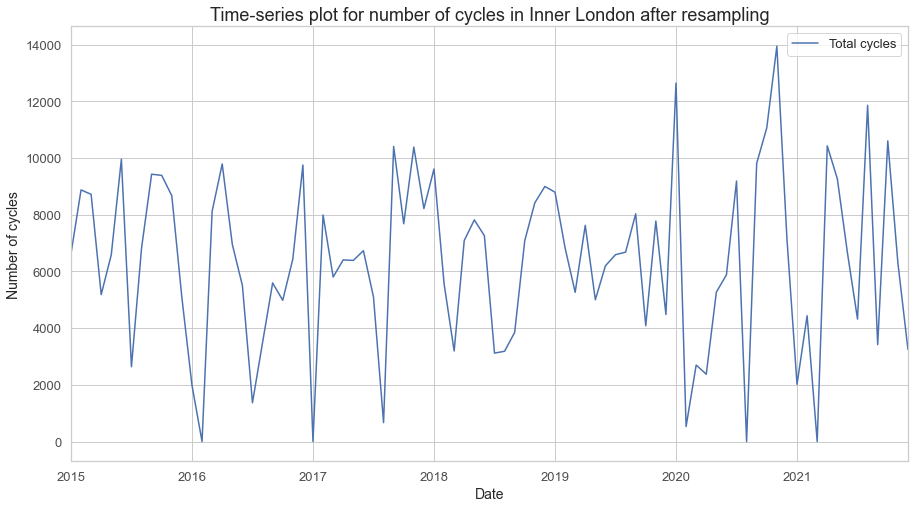

In [104]:
# Plotting the time series data again.
i_ldn_res.plot(figsize = (15, 8))
plt.legend(loc = 'best')
plt.title('Time-series plot for number of cycles in Inner London after resampling')
plt.xlabel('Date')
plt.ylabel('Number of cycles')
plt.show(block = False)

### Forecast - Inner London

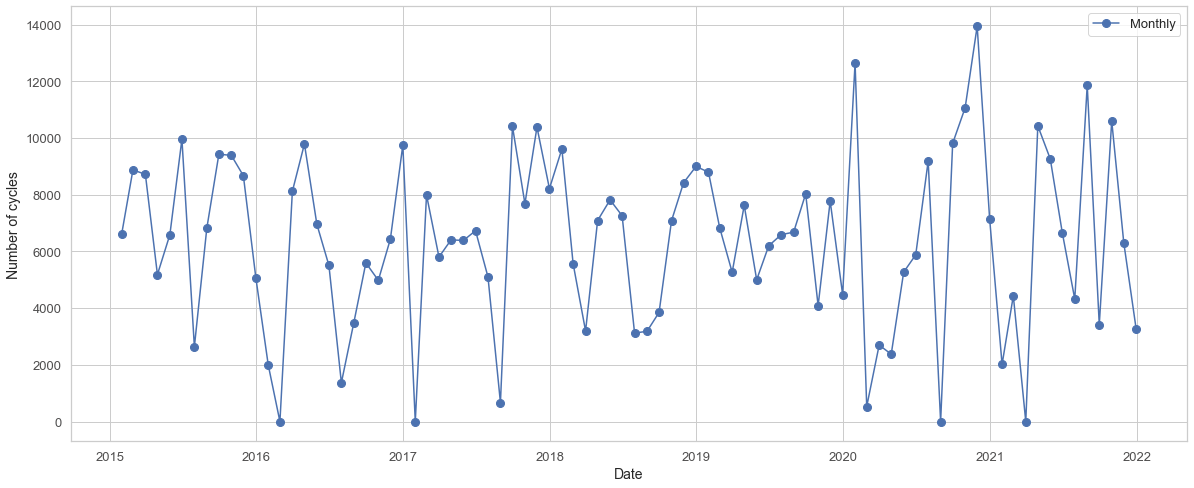

In [105]:
# Define input and visualise.
df1 = i_ldn_res

y = df1['Total cycles']

fig, ax = plt.subplots(figsize = (20, 8))
ax.plot(y, marker = 'o', markersize = 8, linestyle = '-', label = 'Monthly')
ax.set_ylabel('Number of cycles')
ax.set_xlabel('Date')
ax.legend()

#### Decomposing the data

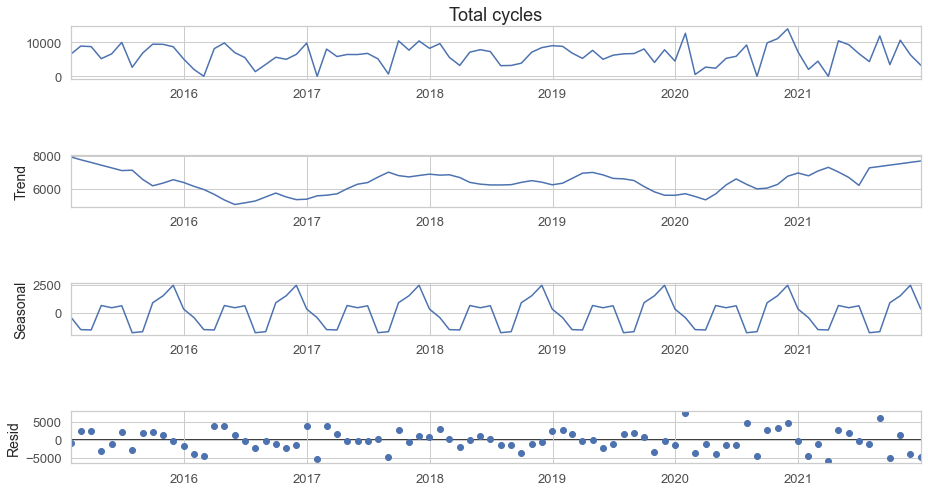

In [106]:
### Decompose the data.
# Visualise to show seasonal_decompose.
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model = 'additive', freq = 12, extrapolate_trend = 'freq')
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)
    plt.show()
    
seasonal_decompose(y)

In [107]:
### After looking at the four pieces decomposed graphs, we can tell that our sales dataset has an overall 
### increasing trend coming to the later stage of the data set as well as a yearly seasonality.

#### Check for Stationarity

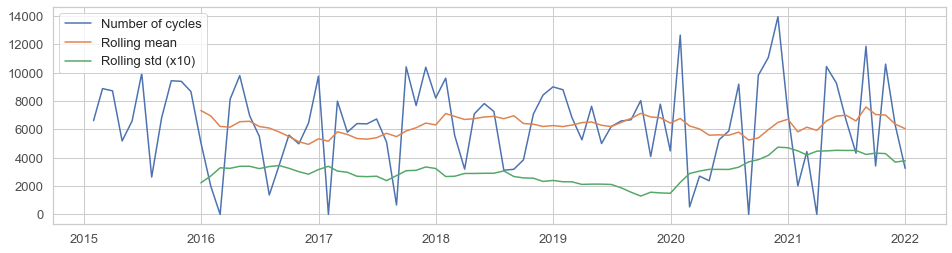

In [108]:
### Plot for Rolling Statistic for testing Stationarity.
def test_stationarity(timeseries, title):
    
    # Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window = 12).mean() 
    rolstd = pd.Series(timeseries).rolling(window = 12).std()
    
    fig, ax = plt.subplots(figsize = (16, 4))
    ax.plot(timeseries, label = 'Number of cycles')
    ax.plot(rolmean, label = 'Rolling mean');
    ax.plot(rolstd, label = 'Rolling std (x10)');
    ax.legend()
    
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y, 'Raw data')

In [109]:
### Both the mean and standard deviation for stationary data does not change much over time.

In [110]:
# Augmented Dickey-Fuller Test
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag = 'AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v < dftest[0] else '', 100-int(k[:-1])))
        
ADF_test(y, 'Raw data')

 > Is the Raw data stationary ?
Test statistic = -6.891
P-value = 0.000
Critical values :
	1%: -3.5137900174243235 - The data is  stationary with 99% confidence
	5%: -2.8979433868293945 - The data is  stationary with 95% confidence
	10%: -2.5861907285474777 - The data is  stationary with 90% confidence


In [111]:
### We can confirm that the data is stationary.

#### Create training and testing data sets

In [112]:
y_to_train = y[:'2019-12-31'] # Dataset to train.
y_to_val = y['2020-01-01':] # Dataset to test.  
predict_date = len(y) - len(y[:'2020-01-01']) # The number of data points for the test set.

#### SARIMA (Seasonal autoregressive integrated moving average)

In [113]:
### Define SARIMA model.

# Use AIC evaluation metric for Grid-search to find parameters (pick one with lowest AIC value).

def sarima_grid_search(y, seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal
                    
                  # print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))
    
sarima_grid_search(y, 12)

The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:1089.027028522784


In [114]:
# Use above parameters to fit the model.
def sarima_eva(y, order, seasonal_order, seasonal_period, pred_date, y_to_test):
    # Fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                    order = order,
                                    seasonal_order = seasonal_order,
                                    enforce_stationarity = False,
                                    enforce_invertibility = False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize = (25, 12))
    plt.show()
    
    # The dynamic = False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start = pd.to_datetime(pred_date), dynamic = False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length = {} and dynamic = False {}'.format(seasonal_period, round(np.sqrt(mse), 2)))

    ax = y.plot(label = 'Observed')
    y_forecasted.plot(ax = ax, label = 'One-step ahead Forecast', alpha = 0.7, figsize = (20, 8))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start = pd.to_datetime(pred_date), dynamic = True, full_results = True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length = {} and dynamic = True {}'.format(seasonal_period, round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label = 'Observed')
    y_forecasted_dynamic.plot(label = 'Dynamic Forecast', ax = ax, figsize = (20, 8))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color = 'k', alpha = 0.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0227      0.295     -0.077      0.939      -0.601       0.556
ma.L1         -0.9532      0.252     -3.783      0.000      -1.447      -0.459
ar.S.L12      -0.2296      0.430     -0.534      0.593      -1.072       0.613
ma.S.L12      -0.7146      0.336     -2.129      0.033      -1.372      -0.057
sigma2      2.369e+07   2.38e-09   9.97e+15      0.000    2.37e+07    2.37e+07


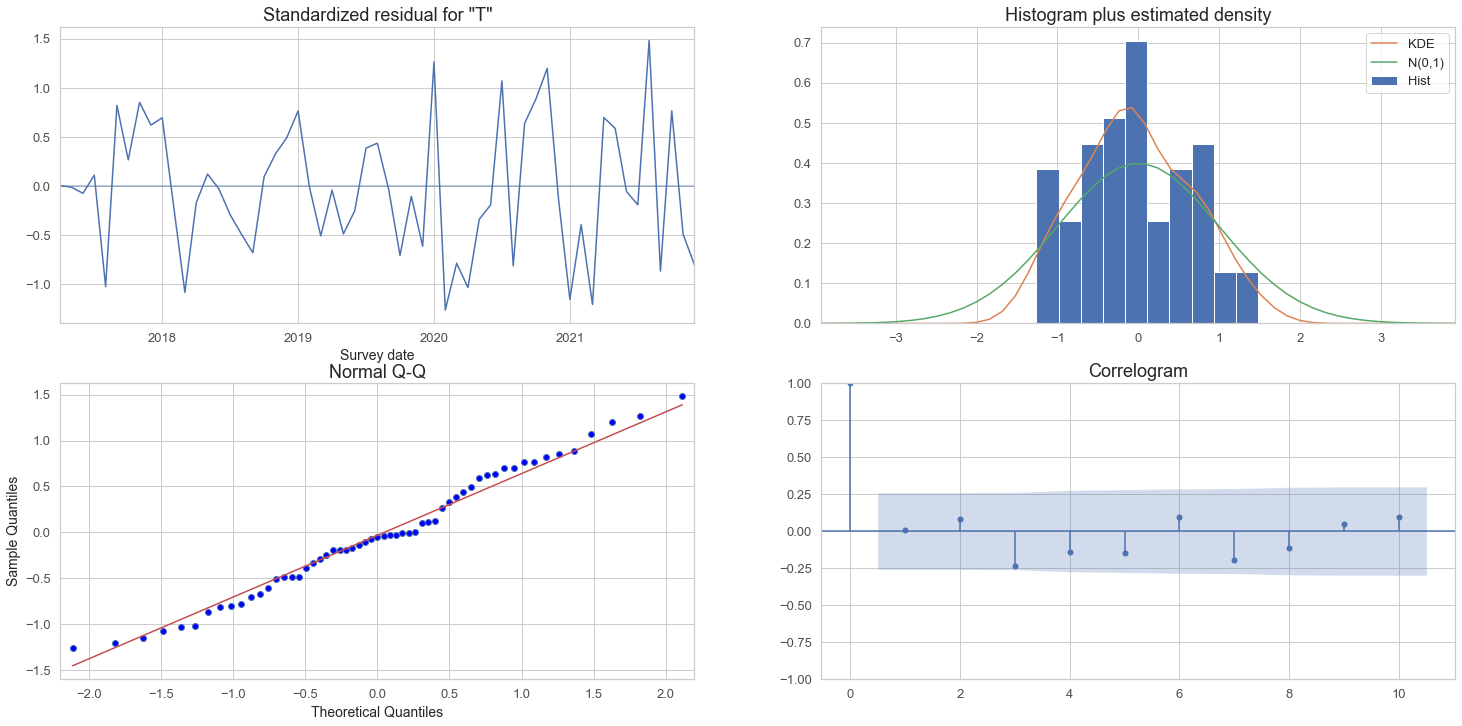

The Root Mean Squared Error of SARIMA with season_length = 12 and dynamic = False 4203.44


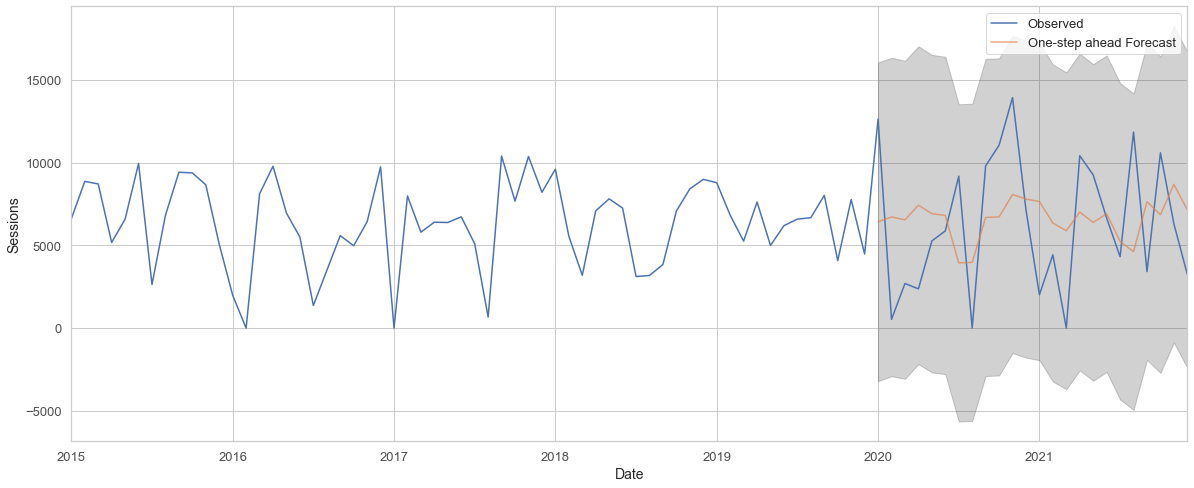

The Root Mean Squared Error of SARIMA with season_length = 12 and dynamic = True 4084.4


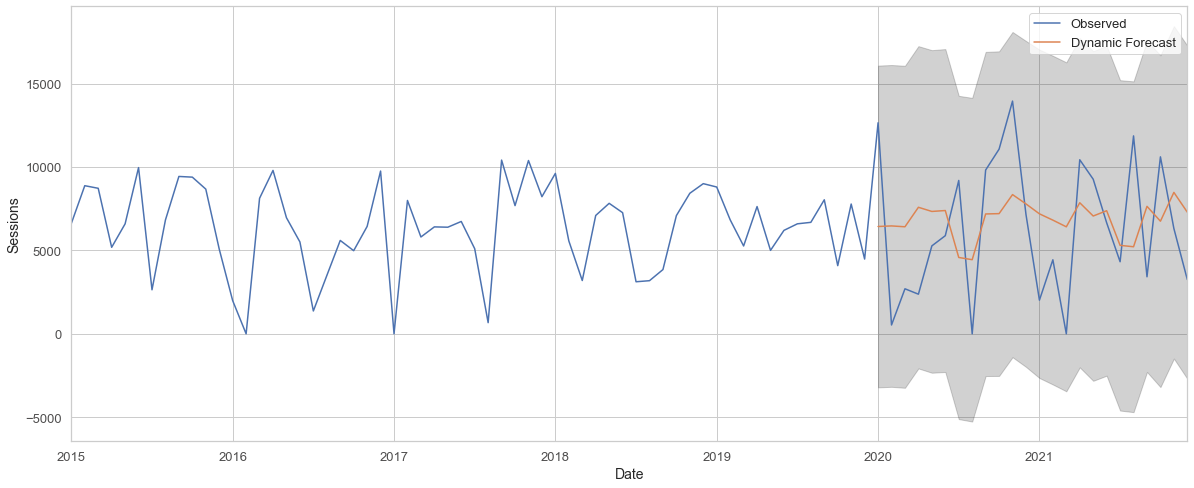

In [115]:
# View results.
model = sarima_eva(y, (1, 1, 1), (1, 1, 1, 12), 12, '2020-01-31', y_to_val)

In [116]:
### By looking at the residuals over time, find out if the residuals are normally distributed, ordered distribution of residuals
### and autocorrelation plot, we can conclude that this model’s residuals are near normally distributed. This indicates we have 
### found a well-fit model suitable for our dataset.

#### Making predictions

In [117]:
# Perform forecasting.
def forecast(model, predict_steps, y):
    
    pred_uc = model.get_forecast(steps = predict_steps)

    # SARIMAXResults.conf_int, can change alpha, the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label = 'Observed', figsize = (20, 10))
    print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax = ax, label = 'Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color = 'k', alpha = 0.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)
    ax.set_title('Predicted number of cycles for Inner London')

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date', 'Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date', 'Lower Bound', 'Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on = 'Date')
    
    return (final_table)

2022-01-31   8385.02740899
2022-02-28   4876.35411718
2022-03-31   4927.87962610
2022-04-30   6415.48111427
2022-05-31   6581.91475835
                  ...     
2023-08-31   6047.64155383
2023-09-30   7034.23096464
2023-10-31   8765.76501316
2023-11-30   9102.60314744
2023-12-31   6209.67391623
Freq: M, Name: predicted_mean, Length: 24, dtype: float64


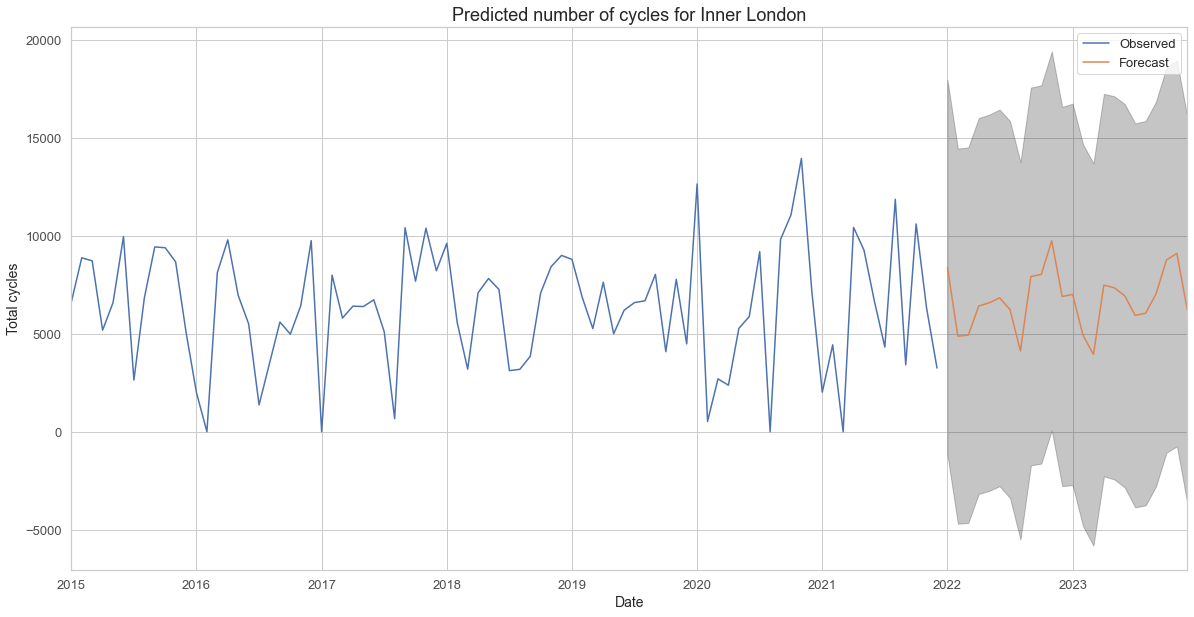

Date  Predicted_Mean    Lower Bound    Upper Bound
0  2022-01-31   8385.02740899 -1185.51426658 17955.56908455
1  2022-02-28   4876.35411718 -4696.03065350 14448.73888786
2  2022-03-31   4927.87962610 -4653.64033123 14509.39958343
3  2022-04-30   6415.48111427 -3175.32507349 16006.28730202
4  2022-05-31   6581.91475835 -3018.49288294 16182.32239965
..        ...             ...            ...            ...
19 2023-08-31   6047.64155383 -3760.27059005 15855.55369771
20 2023-09-30   7034.23096464 -2785.38036856 16853.84229784
21 2023-10-31   8765.76501316 -1066.00072498 18597.53075131
22 2023-11-30   9102.60314744  -741.97797897 18947.18427385
23 2023-12-31   6209.67391623 -3648.67290850 16068.02074095

[24 rows x 4 columns]

In [118]:
# View results (predictions for next 24 months).
final_table = forecast(model, 24, y)
final_table

2022-01-31   8385.02740899
2022-02-28   4876.35411718
2022-03-31   4927.87962610
2022-04-30   6415.48111427
2022-05-31   6581.91475835
                  ...     
2023-08-31   6047.64155383
2023-09-30   7034.23096464
2023-10-31   8765.76501316
2023-11-30   9102.60314744
2023-12-31   6209.67391623
Freq: M, Name: predicted_mean, Length: 24, dtype: float64


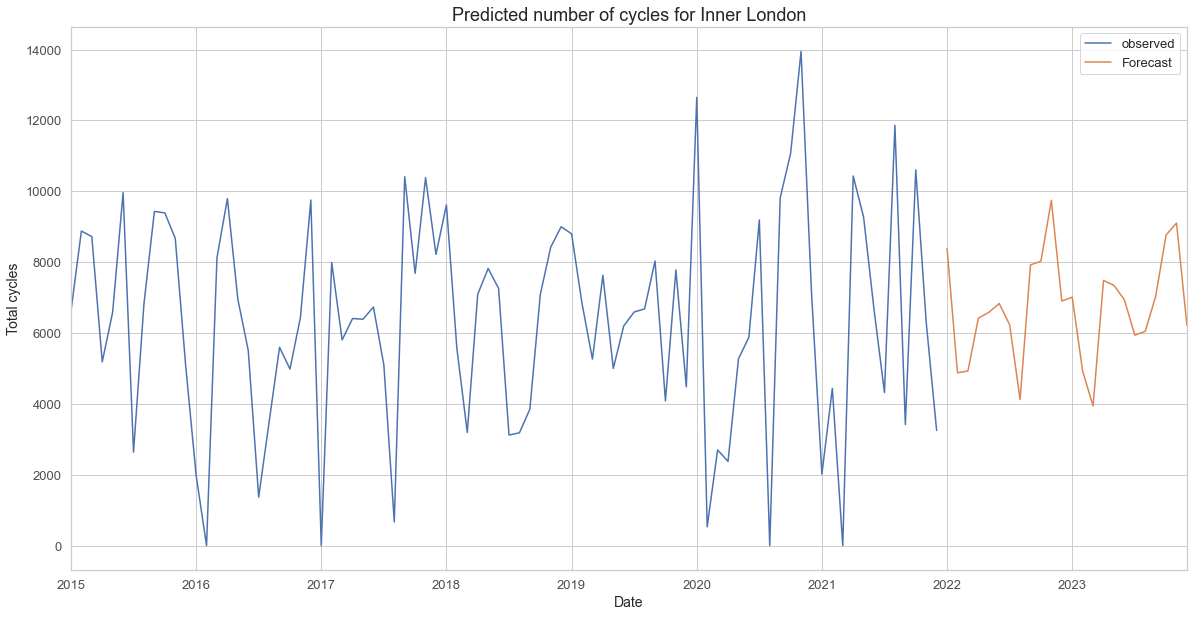

In [119]:
### Graphs without the confident interval.
pred_uc = model.get_forecast(steps = 24)
ax = y.plot(label = 'observed', figsize = (20, 10))
print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax = ax, label = 'Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)
ax.set_title('Predicted number of cycles for Inner London')

plt.legend()
plt.show()

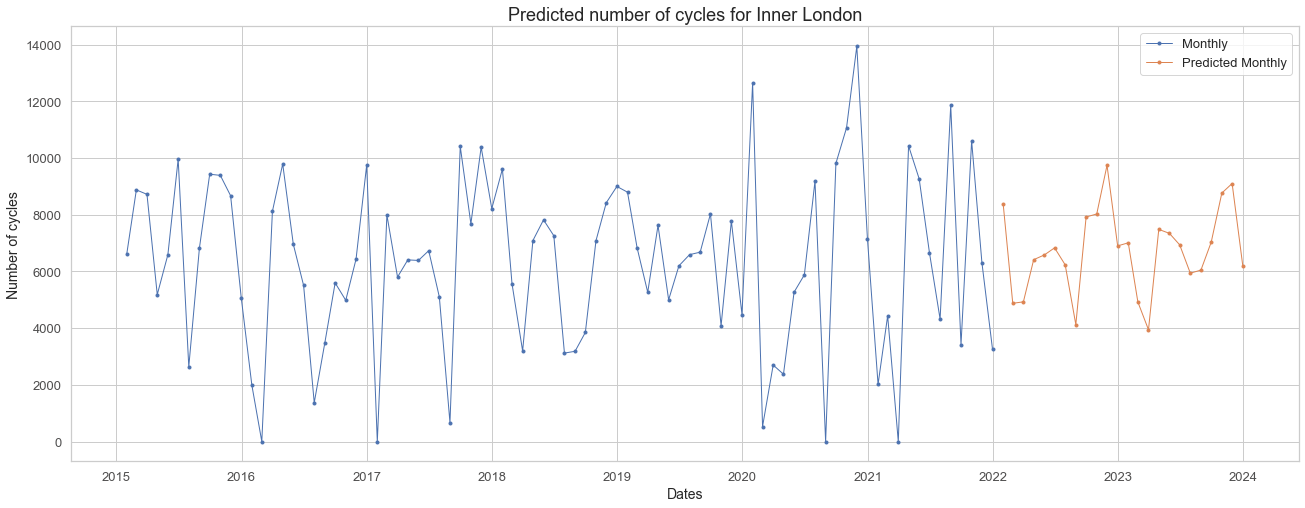

In [120]:
### Graphs show only the perdiected period.
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize = (22, 8))
ax.plot(y, marker = '.', linestyle = '-', linewidth = 1, label = 'Monthly')
ax.plot(final_table.Predicted_Mean, marker = '.', linestyle = '-', linewidth = 1, label = 'Predicted Monthly')
ax.set_ylabel('Number of cycles')
ax.set_xlabel('Dates')
ax.set_title('Predicted number of cycles for Inner London')
ax.legend();

### Outer London

In [121]:
# Use subset_o_london data frame and set date as index.
o_ldn = subset_o_london.set_index('Survey date')

print(o_ldn.info())
o_ldn.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374180 entries, 2015-06-26 to 2021-06-18
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Location                 374180 non-null  object        
 1   Weather                  374180 non-null  object        
 2   Time                     374180 non-null  object        
 3   Period                   374180 non-null  object        
 4   Direction                374180 non-null  object        
 5   Number of male cycles    374180 non-null  int64         
 6   Number of female cycles  374180 non-null  int64         
 7   Total cycles             374180 non-null  int64         
 8   Survey date (Y/M)        374180 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 28.5+ MB
None


Location Weather         Time  \
Survey date                                          
2015-06-26   High Road Leyton     Dry  0600 - 0615   
2015-06-26   High Road Leyton     Dry  0615 - 0630   
2015-06-26   High Road Leyton     Dry  0630 - 0645   
2015-06-26   High Road Leyton     Dry  0645 - 0700   
2015-06-26   High Road Leyton     Dry  0700 - 0715   

                                  Period   Direction  Number of male cycles  \
Survey date                                                                   
2015-06-26   Early Morning (06:00-07:00)  Northbound                      2   
2015-06-26   Early Morning (06:00-07:00)  Northbound                      3   
2015-06-26   Early Morning (06:00-07:00)  Northbound                      2   
2015-06-26   Early Morning (06:00-07:00)  Northbound                      4   
2015-06-26         AM peak (07:00-10:00)  Northbound                      4   

             Number of female cycles  Total cycles Survey date (Y/M)  
Survey date                                                           
2015-06-26                         1             3        2015-06-01  
2015-06-26                         0             3        2015-06-01  
2015-06-26                         0             2        2015-06-01  
2015-06-26                         0             4        2015-06-01  
2015-06-26                         1             5        2015-06-01

In [122]:
# Subset data frame to include only relevant rows.
o_ldn_clean = o_ldn[['Total cycles']]

# Aggregate index (sum same dates).
o_ldn_clean = o_ldn_clean.sum(axis = 0, level = 0)

o_ldn_clean

Total cycles
Survey date              
2015-06-26           2064
2015-06-18           1256
2015-07-20            341
2015-04-06           1418
2015-05-06           1180
...                   ...
2021-06-20             27
2021-02-07            112
2021-07-16            896
2021-07-15             89
2021-07-19             95

[435 rows x 1 columns]

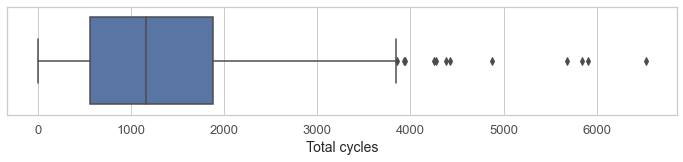

In [123]:
# Determine outliers.
fig = plt.subplots(figsize = (12, 2))
ax = sns.boxplot(x = o_ldn_clean['Total cycles'], whis = 1.5)

In [124]:
# Remove outliers.
cols = ['Total cycles']

# Calculate quantiles and IQR.
Q1 = o_ldn_clean[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100).
Q3 = o_ldn_clean[cols].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

# Return a boolean array of the rows with (any) non-outlier column values.
condition = ~((o_ldn_clean[cols] < (Q1 - 1.5 * IQR)) | \
              (o_ldn_clean[cols] > (Q3 + 1.5 * IQR))).any(axis = 1)

# Filter our dataframe based on condition.
o_ldn_non_outlier = o_ldn_clean[condition]
o_ldn_non_outlier.shape

Total cycles   1317.50000000
dtype: float64


(423, 1)

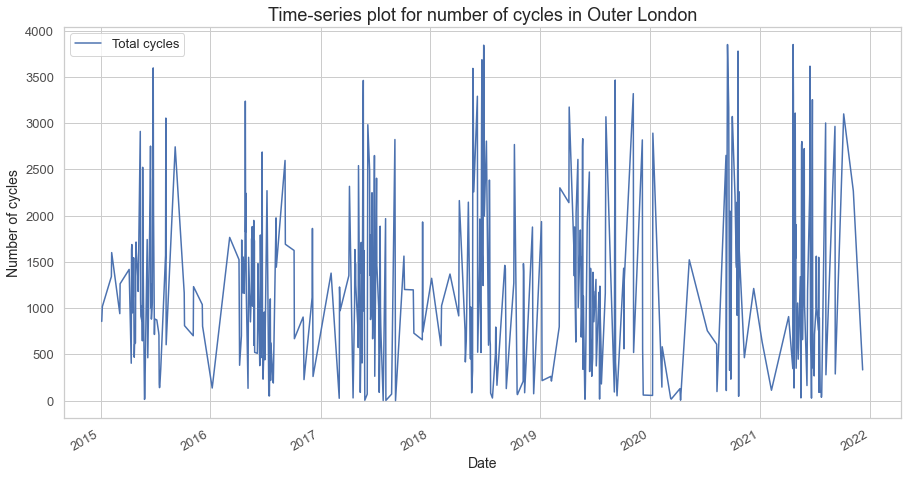

In [125]:
# Plotting the time series data.
o_ldn_non_outlier.plot(figsize = (15, 8))
plt.legend(loc = 'best')
plt.title('Time-series plot for number of cycles in Outer London')
plt.xlabel('Date')
plt.ylabel('Number of cycles')
plt.show(block = False)

In [126]:
# Resampling dataset: 
o_ldn_res = o_ldn_non_outlier.resample('M').mean()

# view DataFrame.
o_ldn_res

Total cycles
Survey date              
2015-01-31   934.66666667
2015-02-28  1470.50000000
2015-03-31  1101.50000000
2015-04-30  1168.60000000
2015-05-31  1184.41666667
...                   ...
2021-08-31  1640.00000000
2021-09-30  1626.00000000
2021-10-31  3099.00000000
2021-11-30  2266.00000000
2021-12-31   332.00000000

[84 rows x 1 columns]

In [127]:
# Fill in any missing values with 0: 
o_ldn_res.fillna(0, inplace = True)

o_ldn_res.isna().sum()

Total cycles    0
dtype: int64

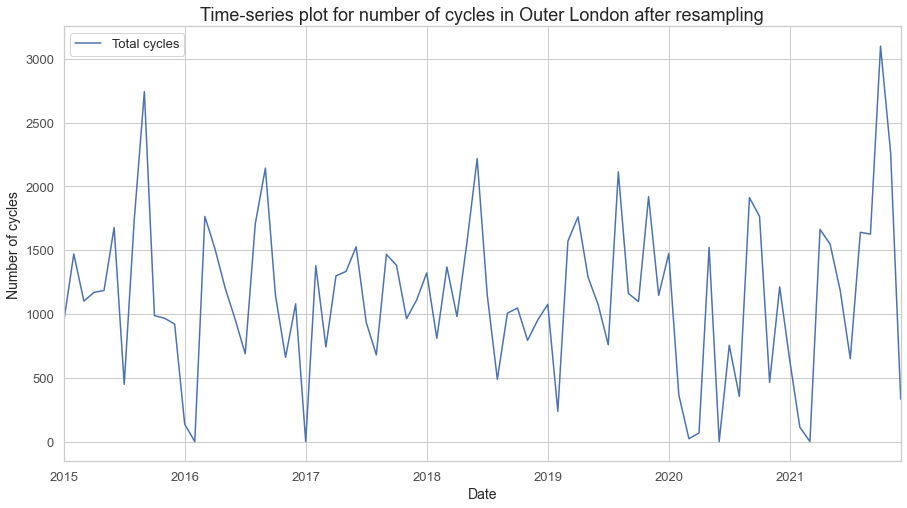

In [128]:
# Plotting the time series data again.
o_ldn_res.plot(figsize = (15, 8))
plt.legend(loc = 'best')
plt.title('Time-series plot for number of cycles in Outer London after resampling')
plt.xlabel('Date')
plt.ylabel('Number of cycles')
plt.show(block = False)

### Forecast - Outer London

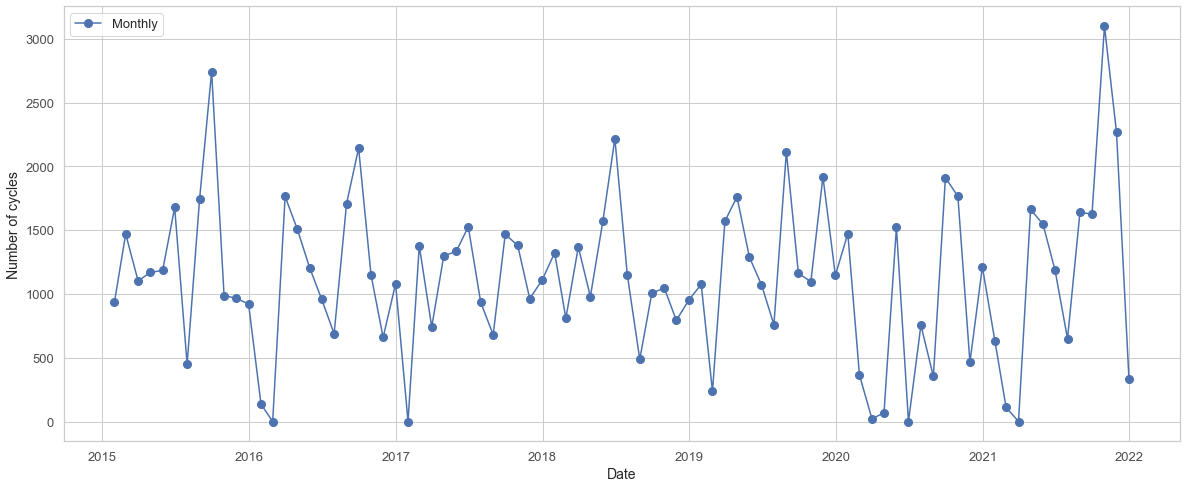

In [129]:
# Define input and visualise.
df2 = o_ldn_res

y = df2['Total cycles']

fig, ax = plt.subplots(figsize = (20, 8))
ax.plot(y, marker = 'o', markersize = 8, linestyle = '-', label = 'Monthly')
ax.set_ylabel('Number of cycles')
ax.set_xlabel('Date')
ax.legend()

#### Decomposing the data

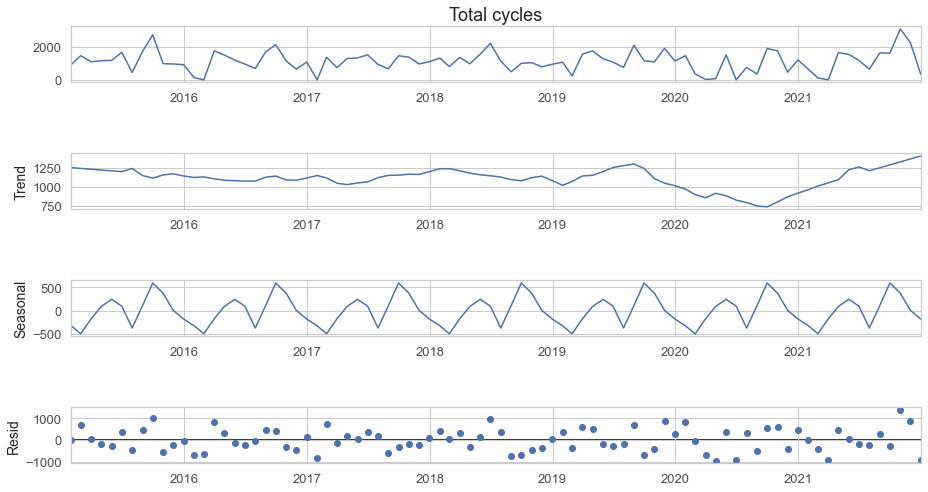

In [130]:
### Decompose the data.
# Visualise to show seasonal_decompose.
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model = 'additive', freq = 12, extrapolate_trend = 'freq')
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)
    plt.show()
    
seasonal_decompose(y)

In [131]:
### After looking at the four pieces decomposed graphs, we can tell that our sales dataset has an overall 
### increasing trend coming to the later stage of the data set as well as a yearly seasonality.

#### Check for Stationarity

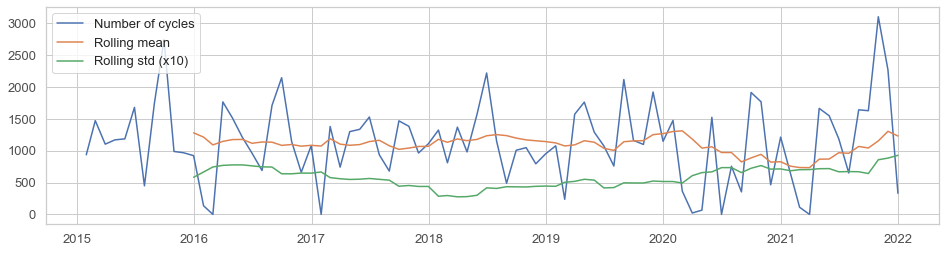

In [132]:
### Plot for Rolling Statistic for testing Stationarity.
def test_stationarity(timeseries, title):
    
    # Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window = 12).mean() 
    rolstd = pd.Series(timeseries).rolling(window = 12).std()
    
    fig, ax = plt.subplots(figsize = (16, 4))
    ax.plot(timeseries, label = 'Number of cycles')
    ax.plot(rolmean, label = 'Rolling mean');
    ax.plot(rolstd, label = 'Rolling std (x10)');
    ax.legend()
    
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y, 'Raw data')

In [133]:
### Both the mean and standard deviation for stationary data does not change much over time.

In [134]:
# Augmented Dickey-Fuller Test
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag = 'AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v < dftest[0] else '', 100-int(k[:-1])))
        
ADF_test(y, 'Raw data')

 > Is the Raw data stationary ?
Test statistic = -7.449
P-value = 0.000
Critical values :
	1%: -3.5117123057187376 - The data is  stationary with 99% confidence
	5%: -2.8970475206326833 - The data is  stationary with 95% confidence
	10%: -2.5857126912469153 - The data is  stationary with 90% confidence


In [135]:
### We can confirm that the data is stationary.

#### Create training and testing data sets

In [136]:
y_to_train = y[:'2019-12-31'] # Dataset to train.
y_to_val = y['2020-01-01':] # Dataset to test.  
predict_date = len(y) - len(y[:'2020-01-01']) # The number of data points for the test set.

#### SARIMA (Seasonal autoregressive integrated moving average)

In [137]:
### Define SARIMA model.

# Use AIC evaluation metric for Grid-search to find parameters (pick one with lowest AIC value).

def sarima_grid_search(y, seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal
                    
                  # print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))
    
sarima_grid_search(y, 12)

The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:914.3656882323171


In [138]:
# Use above parameters to fit the model.
def sarima_eva(y, order, seasonal_order, seasonal_period, pred_date, y_to_test):
    # Fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                    order = order,
                                    seasonal_order = seasonal_order,
                                    enforce_stationarity = False,
                                    enforce_invertibility = False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize = (25, 12))
    plt.show()
    
    # The dynamic = False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start = pd.to_datetime(pred_date), dynamic = False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length = {} and dynamic = False {}'.format(seasonal_period, round(np.sqrt(mse), 2)))

    ax = y.plot(label = 'Observed')
    y_forecasted.plot(ax = ax, label = 'One-step ahead Forecast', alpha = 0.7, figsize = (20, 8))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start = pd.to_datetime(pred_date), dynamic = True, full_results = True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length = {} and dynamic = True {}'.format(seasonal_period, round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label = 'Observed')
    y_forecasted_dynamic.plot(label = 'Dynamic Forecast', ax = ax, figsize = (20, 8))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color = 'k', alpha = 0.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0002      0.188     -5.314      0.000      -1.369      -0.631
ma.S.L12      -0.7692      0.221     -3.485      0.000      -1.202      -0.337
sigma2      4.472e+05   4.18e-07   1.07e+12      0.000    4.47e+05    4.47e+05


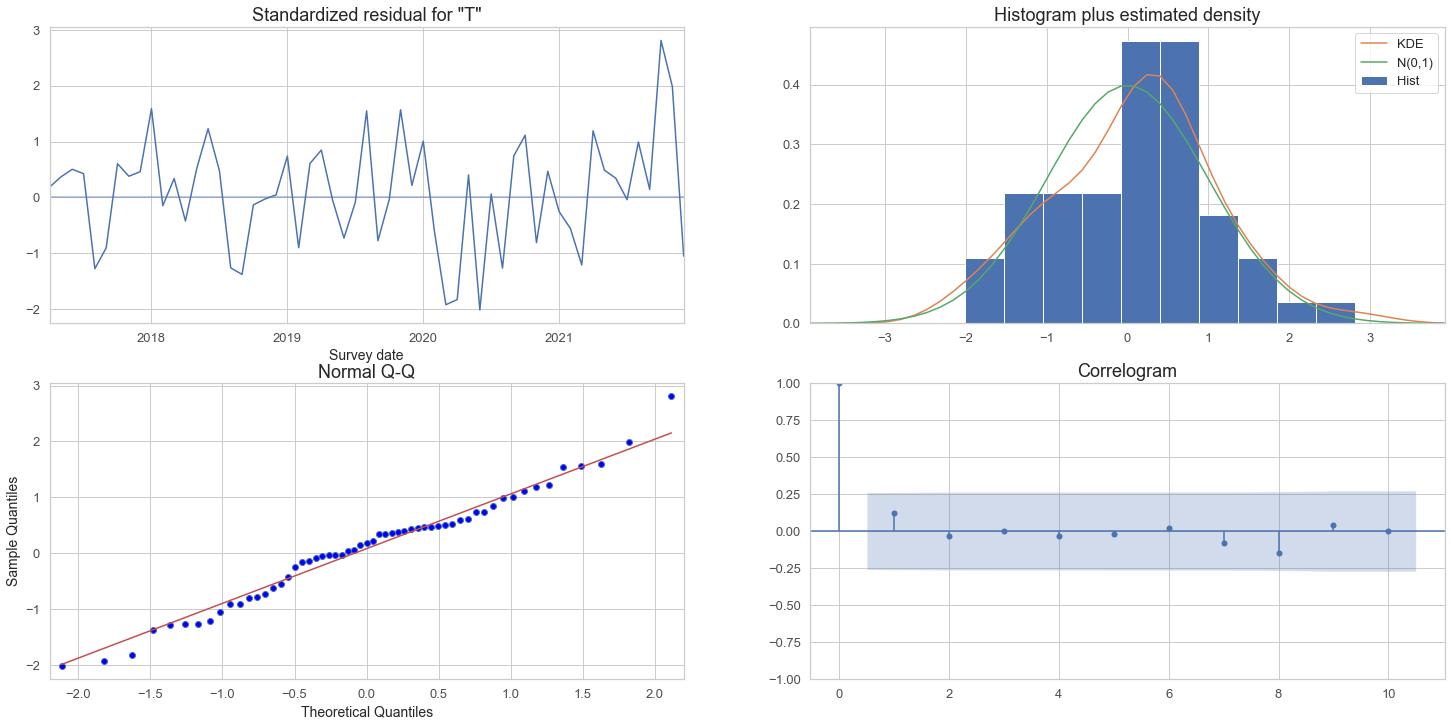

The Root Mean Squared Error of SARIMA with season_length = 12 and dynamic = False 825.24


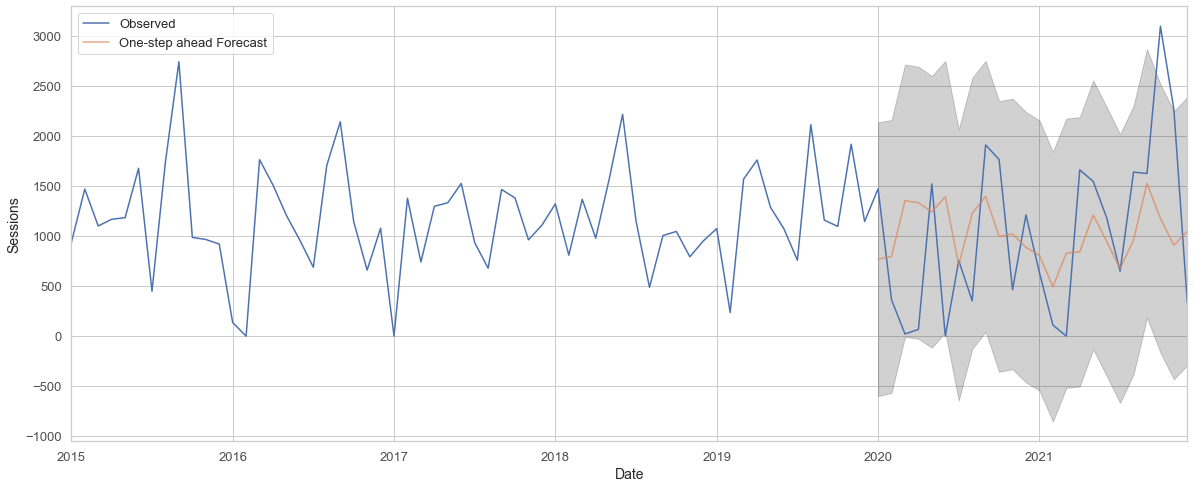

The Root Mean Squared Error of SARIMA with season_length = 12 and dynamic = True 828.88


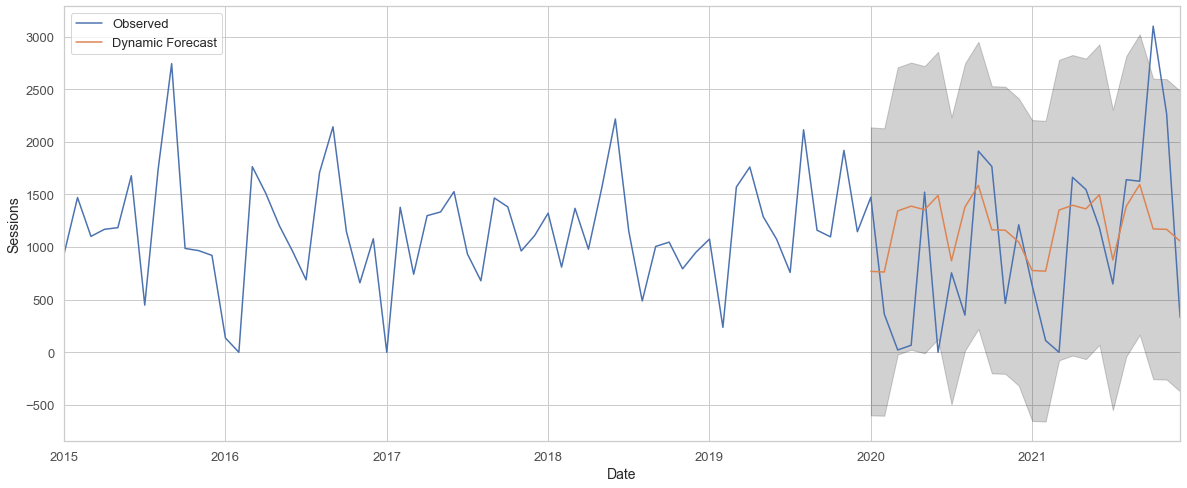

In [139]:
# View results.
model = sarima_eva(y, (0, 1, 1), (0, 1, 1, 12), 12, '2020-01-31', y_to_val)

In [140]:
### By looking at the residuals over time, find out if the residuals are normally distributed, ordered distribution of residuals
### and autocorrelation plot, we can conclude that this model’s residuals are near normally distributed. This indicates we have 
### found a well-fit model suitable for our dataset.

#### Making predictions

In [141]:
# Perform forecasting.
def forecast(model, predict_steps, y):
    
    pred_uc = model.get_forecast(steps = predict_steps)

    # SARIMAXResults.conf_int, can change alpha, the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label = 'Observed', figsize = (20, 10))
    print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax = ax, label = 'Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color = 'k', alpha = 0.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)
    ax.set_title('Predicted number of cycles for Outer London')

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date', 'Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date', 'Lower Bound', 'Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on = 'Date')
    
    return (final_table)

2022-01-31    816.33997943
2022-02-28    464.28092346
2022-03-31    702.70621966
2022-04-30   1139.91315933
2022-05-31   1368.56492918
                  ...     
2023-08-31   1171.39848648
2023-09-30   1582.80703927
2023-10-31   1671.91213435
2023-11-30   1221.47968206
2023-12-31    830.20368518
Freq: M, Name: predicted_mean, Length: 24, dtype: float64


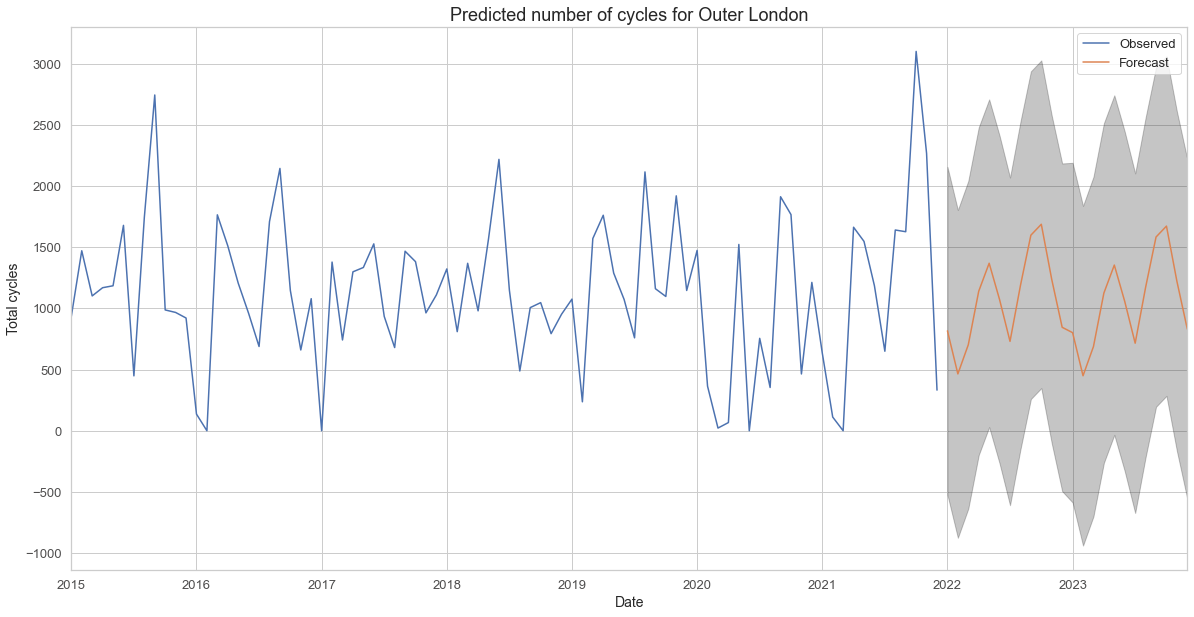

Date  Predicted_Mean   Lower Bound   Upper Bound
0  2022-01-31    816.33997943 -523.21793931 2155.89789818
1  2022-02-28    464.28092346 -874.59463224 1803.15647916
2  2022-03-31    702.70621966 -635.85533559 2041.26777490
3  2022-04-30   1139.91315933 -198.62094384 2478.44726250
4  2022-05-31   1368.56492918   30.03298690 2707.09687147
..        ...             ...           ...           ...
19 2023-08-31   1171.39848648 -215.59200975 2558.38898271
20 2023-09-30   1582.80703927  195.81640837 2969.79767018
21 2023-10-31   1671.91213435  284.92046518 3058.90380351
22 2023-11-30   1221.47968206 -165.52396127 2608.48332539
23 2023-12-31    830.20368518 -556.87970853 2217.28707889

[24 rows x 4 columns]

In [142]:
# View results (predictions for next 24 months).
final_table = forecast(model, 24, y)
final_table

2022-01-31    816.33997943
2022-02-28    464.28092346
2022-03-31    702.70621966
2022-04-30   1139.91315933
2022-05-31   1368.56492918
                  ...     
2023-08-31   1171.39848648
2023-09-30   1582.80703927
2023-10-31   1671.91213435
2023-11-30   1221.47968206
2023-12-31    830.20368518
Freq: M, Name: predicted_mean, Length: 24, dtype: float64


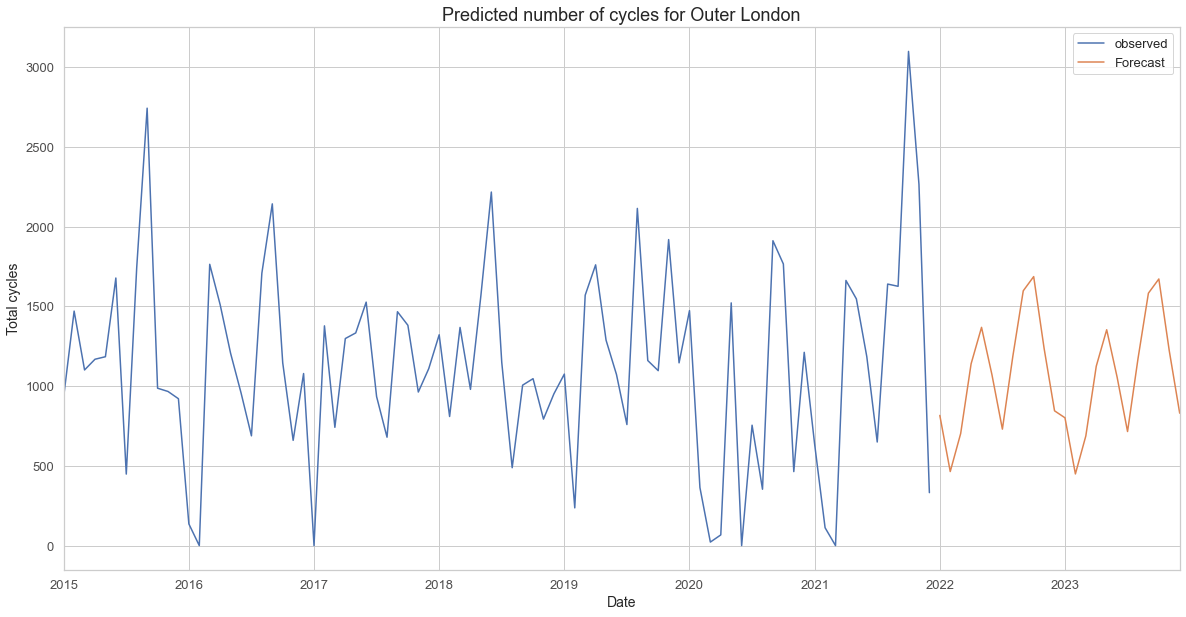

In [143]:
### Graphs without the confident interval.
pred_uc = model.get_forecast(steps = 24)
ax = y.plot(label = 'observed', figsize = (20, 10))
print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax = ax, label = 'Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)
ax.set_title('Predicted number of cycles for Outer London')

plt.legend()
plt.show()

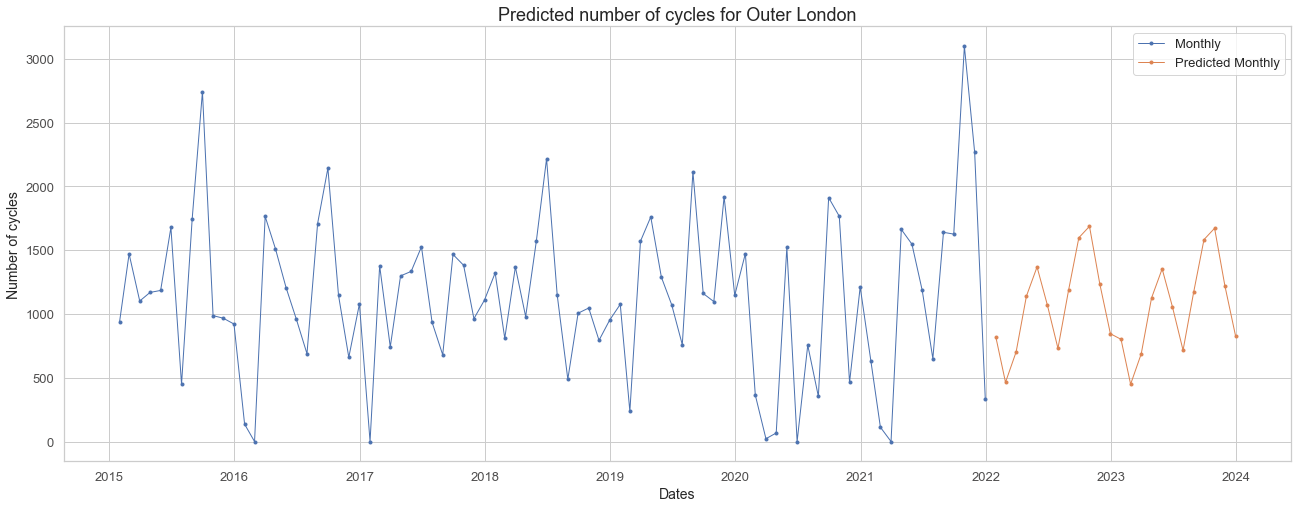

In [144]:
### Graphs show only the perdiected period.
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize = (22, 8))
ax.plot(y, marker = '.', linestyle = '-', linewidth = 1, label = 'Monthly')
ax.plot(final_table.Predicted_Mean, marker = '.', linestyle = '-', linewidth = 1, label = 'Predicted Monthly')
ax.set_ylabel('Number of cycles')
ax.set_xlabel('Dates')
ax.set_title('Predicted number of cycles for Outer London')
ax.legend();

## ***Extra (testing)***

### Central London

In [145]:
# Check data type for columns.
print(c_ldn.info())
c_ldn

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 743061 entries, 2014-01-24 to 2021-12-21
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Survey Year/Quarter  743061 non-null  object 
 1   Location             743061 non-null  object 
 2   Weather              743061 non-null  object 
 3   Time                 743061 non-null  object 
 4   Period               743061 non-null  object 
 5   Direction            743061 non-null  object 
 6   Total cycles         743061 non-null  float64
dtypes: float64(1), object(6)
memory usage: 45.4+ MB
None


Survey Year/Quarter                            Location Weather  \
Survey date                                                                   
2014-01-24             2014 Q1   Millbank (south of Thorney Street)     Dry   
2014-01-24             2014 Q1   Millbank (south of Thorney Street)     Dry   
2014-01-24             2014 Q1   Millbank (south of Thorney Street)     Dry   
2014-01-24             2014 Q1   Millbank (south of Thorney Street)     Dry   
2014-01-24             2014 Q1   Millbank (south of Thorney Street)     Dry   
...                         ...                                 ...     ...   
2021-12-21             2021 Q4                            Haymarket     Dry   
2021-12-21             2021 Q4                            Haymarket     Dry   
2021-12-21             2021 Q4                            Haymarket     Dry   
2021-12-21             2021 Q4                            Haymarket     Dry   
2021-12-21             2021 Q4                            Haymarket     Dry   

                    Time                       Period   Direction  \
Survey date                                                         
2014-01-24   0600 - 0615  Early Morning (06:00-07:00)  Northbound   
2014-01-24   0615 - 0630  Early Morning (06:00-07:00)  Northbound   
2014-01-24   0630 - 0645  Early Morning (06:00-07:00)  Northbound   
2014-01-24   0645 - 0700  Early Morning (06:00-07:00)  Northbound   
2014-01-24   0700 - 0715        AM peak (07:00-10:00)  Northbound   
...                  ...                          ...         ...   
2021-12-21   2045 - 2100        Evening (19:00-22:00)  Southbound   
2021-12-21   2100 - 2115        Evening (19:00-22:00)  Southbound   
2021-12-21   2115 - 2130        Evening (19:00-22:00)  Southbound   
2021-12-21   2130 - 2145        Evening (19:00-22:00)  Southbound   
2021-12-21   2145 - 2200        Evening (19:00-22:00)  Southbound   

             Total cycles  
Survey date                
2014-01-24     0.00000000  
2014-01-24    15.00000000  
2014-01-24    35.00000000  
2014-01-24    61.00000000  
2014-01-24    73.00000000  
...                   ...  
2021-12-21    23.00000000  
2021-12-21    20.00000000  
2021-12-21    17.00000000  
2021-12-21    11.00000000  
2021-12-21    14.00000000  

[743061 rows x 7 columns]

In [146]:
# Define regression_results function to print all performance metrics relevant to a regression task.
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance, 4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error, 4))
    print('r2: ', round(r2, 4))
    print('MAE: ', round(mean_absolute_error, 4))
    print('MSE: ', round(mse, 4))
    print('RMSE: ', round(np.sqrt(mse), 4))

In [147]:
# Creating new dataframe from total cycles column.
c_ldn_total_cycles = c_ldn[['Total cycles']].sort_index()

# Inserting new column with yesterday's total cycles values.
c_ldn_total_cycles.loc[:, 'Yesterday'] = c_ldn_total_cycles.loc[:, 'Total cycles'].shift()

# Inserting another column with difference between yesterday and day before yesterday's total cycles values.
c_ldn_total_cycles.loc[:, 'Yesterday_Diff'] = c_ldn_total_cycles.loc[:, 'Yesterday'].diff()

# Dropping NAs.
c_ldn_total_cycles = c_ldn_total_cycles.dropna()

# View dataframe.
c_ldn_total_cycles

Total cycles   Yesterday  Yesterday_Diff
Survey date                                          
2014-01-04    31.00000000 67.00000000     50.00000000
2014-01-04    21.00000000 31.00000000    -36.00000000
2014-01-04    24.00000000 21.00000000    -10.00000000
2014-01-04    24.00000000 24.00000000      3.00000000
2014-01-04    10.00000000 24.00000000      0.00000000
...                   ...         ...             ...
2021-12-30    22.00000000 25.00000000     -4.00000000
2021-12-30    13.00000000 22.00000000     -3.00000000
2021-12-30    16.00000000 13.00000000     -9.00000000
2021-12-30     7.00000000 16.00000000      3.00000000
2021-12-30    19.00000000  7.00000000     -9.00000000

[743059 rows x 3 columns]

In [148]:
# Sum all the values based on index (same date).
c_ldn_total_cycles = c_ldn_total_cycles.sum(axis = 0, level = 0)

c_ldn_total_cycles

Total cycles      Yesterday  Yesterday_Diff
Survey date                                              
2014-01-04   9153.00000000  9219.00000000    -11.00000000
2014-01-05    603.00000000   603.00000000     -6.00000000
2014-01-07  10379.00000000 10378.00000000      9.00000000
2014-01-08   1431.00000000  1430.00000000     -7.00000000
2014-01-10   2750.00000000  2749.00000000      5.00000000
...                    ...            ...             ...
2021-12-21    310.00000000   312.00000000    -14.00000000
2021-12-22    247.00000000   254.00000000      7.00000000
2021-12-23    137.00000000   140.00000000      3.00000000
2021-12-24    215.00000000   206.00000000      1.00000000
2021-12-30    220.00000000   214.00000000     -5.00000000

[1596 rows x 3 columns]

In [149]:
# Define training and testing sets (I'm using 2014 to 2020 for training, and 2021 for testing).
X_train = c_ldn_total_cycles[:'2020'].drop(['Total cycles'], axis = 1)
y_train = c_ldn_total_cycles.loc[:'2020', 'Total cycles']
X_test = c_ldn_total_cycles['2021'].drop(['Total cycles'], axis = 1)
y_test = c_ldn_total_cycles.loc['2021', 'Total cycles']

LR: 0.999961 (0.000009)
NN: 0.999961 (0.000009)
KNN: 0.999438 (0.000437)
RF: 0.999239 (0.000744)
SVR: -0.054837 (0.031608)


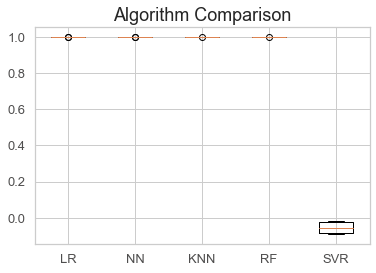

In [150]:
# Spot Check Algorithms.
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  # Neural network
models.append(('KNN', KNeighborsRegressor()))
models.append(('RF', RandomForestRegressor(n_estimators = 6))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma = 'auto'))) # kernel = linear 
### MLPRegressor and SVM are taking too long to run, so I'm not using them for Central London.

# Evaluate each model in turn.
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits = 6)
    
    cv_results = cross_val_score(model, X_train, y_train, cv = tscv, scoring = 'r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms.
plt.boxplot(results, labels = names)
plt.title('Algorithm Comparison')
plt.show()

In [151]:
### LR performed best, but I'd go for RF since this ensemble model.
### (it combines models together and delivers better prediction).

# Define a custom scorer.
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [152]:
# Grid-search hyperparameters.
model = RandomForestRegressor()

param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5, 15)]
}
tscv = TimeSeriesSplit(n_splits = 6)
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = rmse_score, n_jobs = -1)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [153]:
# Check best model performance on test data.
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.9999
mean_squared_log_error:  0.0012
r2:  0.9999
MAE:  25.2193
MSE:  1283.365
RMSE:  35.8241
